In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Prepare data
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
root = "/tmp"
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 1000

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

for X_train, y_train in train_loader:
    break
for X_val, y_val in test_loader:
    break
    
if True:
    X_train = X_train.double()
    X_val = X_val.double()
    
if torch.cuda.is_available():
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

In [3]:
# Build model
from tda.models import pytorch_lenet
lenet = pytorch_lenet.LeNet()
lenet.train_or_load()
if torch.cuda.is_available():
    lenet = lenet.cuda()

2020-05-15 07:46:53,403 - Devices - INFO - Found 0 devices compatible with CUDA


Loaded LeNet_pretrained.pth


In [4]:
# Load or train model
lenet.train_or_load(train_loader=[(X_train, y_train)], val_data=(X_val, y_val),
                    num_epochs=50)

Loaded LeNet_pretrained.pth


In [5]:
# Build architecture (tda pipeline terminology)
import tda.models.architectures.parser as parser
from imp import reload
reload(parser)

x = X_train[0]
lenet_arch = parser.model_to_architecture(lenet, name="mnist_lenet",
                                          x=x)

2020-05-15 07:46:54,018 - ConvLayer - INFO - <tda.models.layers.conv_layer.ConvLayer object at 0x7fe2483f5490> received input with shape torch.Size([1, 1, 28, 28])


INFO:ConvLayer:<tda.models.layers.conv_layer.ConvLayer object at 0x7fe2483f5490> received input with shape torch.Size([1, 1, 28, 28])


2020-05-15 07:46:54,020 - ConvLayer - INFO - <tda.models.layers.conv_layer.ConvLayer object at 0x7fe2483f5690> received input with shape torch.Size([1, 20, 12, 12])


INFO:ConvLayer:<tda.models.layers.conv_layer.ConvLayer object at 0x7fe2483f5690> received input with shape torch.Size([1, 20, 12, 12])
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=64)
           2	LOAD_FAST(arg=0, lineno=64)
           4	LOAD_ATTR(arg=0, lineno=64)
           6	LOAD_CONST(arg=1, lineno=64)
           8	BINARY_SUBSCR(arg=None, lineno=64)
          10	STORE_FAST(arg=6, lineno=64)
          12	LOAD_FAST(arg=0, lineno=65)
          14	LOAD_ATTR(arg=0, lineno=65)
          16	LOAD_CONST(arg=2, lineno=65)
          18	BINARY_SUBSCR(arg=None, lineno=65)
          20	STORE_FAST(arg=7, lineno=65)
          22	LOAD_FAST(arg=1, lineno=67)
          24	LOAD_CONST(arg=3, lineno=67)
          26	LOAD_FAST(arg=5, lineno=67)
          28	BINARY_MULTIPLY(arg=None, lineno=67)
          30	BINARY_ADD(arg=None, lineno=67)
          32	STORE_FAST(arg=8, lineno=67)
          34	LOAD_FAST(arg=2, lineno=68)
          36	LOAD_CONST(arg=3, lineno=68)
          38	L

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=64)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=64)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_ATTR(arg=0, lineno=64)
DEBUG:numba.core.byteflow:stack ['$kernel2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=LOAD_CONST(arg=1, lineno=64)
DEBUG:numba.core.byteflow:stack ['$4load_attr.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=BINARY_SUBSCR(arg=None, lineno=64)
DEBUG:numba.core.byteflow:stack ['$4load_attr.1', '$const6.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=STORE_FAST(arg=6, lineno=64)
DEBUG:numba.core.byteflow:stack ['$8binary_subscr.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=0, lineno=65)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=

DEBUG:numba.core.byteflow:stack ['$82load_global.34', '$const84.35', '$102binary_add.44', '$const104.45']
DEBUG:numba.core.byteflow:dispatch pc=108, inst=BINARY_MULTIPLY(arg=None, lineno=74)
DEBUG:numba.core.byteflow:stack ['$82load_global.34', '$const84.35', '$102binary_add.44', '$const104.45', '$padding106.46']
DEBUG:numba.core.byteflow:dispatch pc=110, inst=BINARY_ADD(arg=None, lineno=74)
DEBUG:numba.core.byteflow:stack ['$82load_global.34', '$const84.35', '$102binary_add.44', '$108binary_multiply.47']
DEBUG:numba.core.byteflow:dispatch pc=112, inst=LOAD_FAST(arg=4, lineno=74)
DEBUG:numba.core.byteflow:stack ['$82load_global.34', '$const84.35', '$110binary_add.48']
DEBUG:numba.core.byteflow:dispatch pc=114, inst=CALL_FUNCTION(arg=3, lineno=74)
DEBUG:numba.core.byteflow:stack ['$82load_global.34', '$const84.35', '$110binary_add.48', '$stride112.49']
DEBUG:numba.core.byteflow:dispatch pc=116, inst=STORE_FAST(arg=12, lineno=74)
DEBUG:numba.core.byteflow:stack ['$114call_function.50']
D

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=182 nstack_initial=2)])
DEBUG:numba.core.byteflow:stack: ['$phi182.0', '$phi182.1']
DEBUG:numba.core.byteflow:dispatch pc=182, inst=FOR_ITER(arg=298, lineno=84)
DEBUG:numba.core.byteflow:stack ['$phi182.0', '$phi182.1']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=484, stack=('$phi182.0',), blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}), npush=0), Edge(pc=186, stack=('$phi182.0', '$phi182.1', '$182for_iter.3'), blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=484 nstack_initial=1), State(pc_initial=186 nstack_initial=3)])
DEBUG:numba.core.byteflow:stack: ['$phi4

DEBUG:numba.core.byteflow:stack ['$phi210.0', '$phi210.1', '$phi210.2', '$phi210.3']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=476, stack=('$phi210.0', '$phi210.1', '$phi210.2'), blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 482, 'entry_stack': 2, 'stack_depth': 2, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 478, 'entry_stack': 3, 'stack_depth': 3, 'handler': None}), npush=0), Edge(pc=214, stack=('$phi210.0', '$phi210.1', '$phi210.2', '$phi210.3', '$210for_iter.5'), blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 482, 'entry_stack': 2, 'stack_depth': 2, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 478, 'en

DEBUG:numba.core.byteflow:stack ['$phi214.0', '$phi214.1', '$phi214.2', '$phi214.3', '$272compare_op.31']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=278, stack=('$phi214.0', '$phi214.1', '$phi214.2', '$phi214.3'), blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 482, 'entry_stack': 2, 'stack_depth': 2, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 478, 'entry_stack': 3, 'stack_depth': 3, 'handler': None}), npush=0), Edge(pc=356, stack=('$phi214.0', '$phi214.1', '$phi214.2', '$phi214.3'), blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 482, 'entry_stack': 2, 'stack_depth': 2, 'handler': None}, {'kind': BlockKind(LOOP),

DEBUG:numba.core.byteflow:dispatch pc=400, inst=BINARY_SUBSCR(arg=None, lineno=118)
DEBUG:numba.core.byteflow:stack ['$phi356.0', '$phi356.1', '$phi356.2', '$phi356.3', '$const394.20', '$row_ind396.21', '$const398.22']
DEBUG:numba.core.byteflow:dispatch pc=402, inst=DUP_TOP(arg=None, lineno=118)
DEBUG:numba.core.byteflow:stack ['$phi356.0', '$phi356.1', '$phi356.2', '$phi356.3', '$const394.20', '$400binary_subscr.23']
DEBUG:numba.core.byteflow:dispatch pc=404, inst=ROT_THREE(arg=None, lineno=118)
DEBUG:numba.core.byteflow:stack ['$phi356.0', '$phi356.1', '$phi356.2', '$phi356.3', '$const394.20', '$400binary_subscr.23', '$402dup_top.24']
DEBUG:numba.core.byteflow:dispatch pc=406, inst=COMPARE_OP(arg=1, lineno=118)
DEBUG:numba.core.byteflow:stack ['$phi356.0', '$phi356.1', '$phi356.2', '$phi356.3', '$402dup_top.24', '$const394.20', '$400binary_subscr.23']
DEBUG:numba.core.byteflow:dispatch pc=408, inst=POP_JUMP_IF_FALSE(arg=430, lineno=118)
DEBUG:numba.core.byteflow:stack ['$phi356.0', '

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=430 nstack_initial=5), State(pc_initial=306 nstack_initial=4), State(pc_initial=210 nstack_initial=4), State(pc_initial=428 nstack_initial=4), State(pc_initial=466 nstack_initial=4)])
DEBUG:numba.core.byteflow:stack: ['$phi430.0', '$phi430.1', '$phi430.2', '$phi430.3', '$phi430.4']
DEBUG:numba.core.byteflow:dispatch pc=430, inst=POP_TOP(arg=None, lineno=118)
DEBUG:numba.core.byteflow:stack ['$phi430.0', '$phi430.1', '$phi430.2', '$phi430.3', '$phi430.4']
DEBUG:numba.core.byteflow:dispatch pc=432, inst=JUMP_FORWARD(arg=32, lineno=118)
DEBUG:numba.core.byteflow:stack ['$phi430.0', '$phi430.1', '$phi430.2', '$phi430.3']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=466, stack=('$phi430.0', '$phi430.1', '$phi430.2', '$phi430.3'), blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}, {'k

DEBUG:numba.core.byteflow:dispatch pc=332, inst=BINARY_SUBTRACT(arg=None, lineno=109)
DEBUG:numba.core.byteflow:stack ['$phi324.0', '$phi324.1', '$phi324.2', '$phi324.3', '$328binary_subtract.6', '$padding330.7']
DEBUG:numba.core.byteflow:dispatch pc=334, inst=LOAD_FAST(arg=23, lineno=111)
DEBUG:numba.core.byteflow:stack ['$phi324.0', '$phi324.1', '$phi324.2', '$phi324.3', '$332binary_subtract.8']
DEBUG:numba.core.byteflow:dispatch pc=336, inst=LOAD_FAST(arg=8, lineno=111)
DEBUG:numba.core.byteflow:stack ['$phi324.0', '$phi324.1', '$phi324.2', '$phi324.3', '$332binary_subtract.8', '$col334.9']
DEBUG:numba.core.byteflow:dispatch pc=338, inst=BINARY_FLOOR_DIVIDE(arg=None, lineno=111)
DEBUG:numba.core.byteflow:stack ['$phi324.0', '$phi324.1', '$phi324.2', '$phi324.3', '$332binary_subtract.8', '$col334.9', '$nbcols_input_with_padding336.10']
DEBUG:numba.core.byteflow:dispatch pc=340, inst=LOAD_CONST(arg=5, lineno=111)
DEBUG:numba.core.byteflow:stack ['$phi324.0', '$phi324.1', '$phi324.2', 

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=464 nstack_initial=5), State(pc_initial=462 nstack_initial=4), State(pc_initial=210 nstack_initial=4)])
DEBUG:numba.core.byteflow:stack: ['$phi464.0', '$phi464.1', '$phi464.2', '$phi464.3', '$phi464.4']
DEBUG:numba.core.byteflow:dispatch pc=464, inst=POP_TOP(arg=None, lineno=119)
DEBUG:numba.core.byteflow:stack ['$phi464.0', '$phi464.1', '$phi464.2', '$phi464.3', '$phi464.4']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=466, stack=('$phi464.0', '$phi464.1', '$phi464.2', '$phi464.3'), blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 482, 'entry_stack': 2, 'stack_depth': 2, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 478, 'entry_stack': 3, 'stack_depth': 3, 'handler': None}), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_ini

DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>,
            {'$phi164.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0)),
                           ('$phi484.0',
                            State(pc_initial=484 nstack_initial=1))},
             '$phi168.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0)),
                           ('$phi484.0',
                            State(pc_initial=484 nstack_initial=1))},
             '$phi168.1': {('$164for_iter.2',
                            State(pc_initial=164 nstack_initial=1))},
             '$phi170.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0)),
                           ('$phi484.0',
                            State(pc_initial=484 nstack_initial=1))},
             '$phi182.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0)),
                    

DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>,
            {'$phi164.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0)),
                           ('$phi480.0',
                            State(pc_initial=480 nstack_initial=2))},
             '$phi168.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0)),
                           ('$phi480.0',
                            State(pc_initial=480 nstack_initial=2))},
             '$phi168.1': {('$164for_iter.2',
                            State(pc_initial=164 nstack_initial=1))},
             '$phi170.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0)),
                           ('$phi480.0',
                            State(pc_initial=480 nstack_initial=2))},
             '$phi182.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0)),
                    

DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>,
            {'$phi164.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0))},
             '$phi168.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0))},
             '$phi168.1': {('$164for_iter.2',
                            State(pc_initial=164 nstack_initial=1))},
             '$phi170.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0))},
             '$phi182.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0))},
             '$phi182.1': {('$180get_iter.4',
                            State(pc_initial=170 nstack_initial=1))},
             '$phi186.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0))},
             '$phi186.1': {('$180get_iter.4',
                            State(pc_initial=170 nstack_initial=1))},
 

DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>,
            {'$phi164.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0))},
             '$phi168.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0))},
             '$phi168.1': {('$164for_iter.2',
                            State(pc_initial=164 nstack_initial=1))},
             '$phi170.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0))},
             '$phi182.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0))},
             '$phi182.1': {('$180get_iter.4',
                            State(pc_initial=170 nstack_initial=1))},
             '$phi186.0': {('$162get_iter.3',
                            State(pc_initial=152 nstack_initial=0))},
             '$phi186.1': {('$180get_iter.4',
                            State(pc_initial=170 nstack_initial=1))},
 

DEBUG:numba.core.byteflow:keep phismap: {'$phi164.0': {('$162get_iter.3', State(pc_initial=152 nstack_initial=0))},
 '$phi168.1': {('$164for_iter.2', State(pc_initial=164 nstack_initial=1))},
 '$phi182.1': {('$180get_iter.4', State(pc_initial=170 nstack_initial=1))},
 '$phi186.2': {('$182for_iter.3', State(pc_initial=182 nstack_initial=2))},
 '$phi196.2': {('$194get_iter.3', State(pc_initial=188 nstack_initial=2))},
 '$phi200.3': {('$196for_iter.4', State(pc_initial=196 nstack_initial=3))},
 '$phi210.3': {('$208get_iter.4', State(pc_initial=202 nstack_initial=3))},
 '$phi214.4': {('$210for_iter.5', State(pc_initial=210 nstack_initial=4))},
 '$phi412.4': {('$402dup_top.24', State(pc_initial=356 nstack_initial=4))},
 '$phi452.4': {('$442dup_top.8', State(pc_initial=434 nstack_initial=4))}}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=152 nstack_initial=0): {'$phi164.0': '$162get_iter.3'},
             State(pc_initial=164 nstack_initial=1):

DEBUG:numba.core.byteflow:block_infos State(pc_initial=186 nstack_initial=3):
AdaptBlockInfo(insts=((186, {'value': '$phi186.2'}),), outgoing_phis={}, blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}), active_try_block=None, outgoing_edgepushed={188: ('$phi186.0', '$phi186.1')})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=188 nstack_initial=2):
AdaptBlockInfo(insts=((192, {'res': '$offsets_i192.2'}), (194, {'value': '$offsets_i192.2', 'res': '$194get_iter.3'})), outgoing_phis={'$phi196.2': '$194get_iter.3'}, blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}), active_try_block=None, outgoing_edgepushed={196: ('$phi188.0', '$phi188.1', '$194get_iter.3')})
DEBUG:numba.core.byteflow:block_info

DEBUG:numba.core.byteflow:block_infos State(pc_initial=306 nstack_initial=4):
AdaptBlockInfo(insts=((306, {'res': '$col306.4'}), (308, {'res': '$nbcols_with_padding308.5'}), (310, {'res': '$nbcols_input_with_padding310.6'}), (312, {'lhs': '$nbcols_with_padding308.5', 'rhs': '$nbcols_input_with_padding310.6', 'res': '$312binary_subtract.7'}), (314, {'lhs': '$col306.4', 'rhs': '$312binary_subtract.7', 'res': '$314compare_op.8'}), (316, {'pred': '$314compare_op.8'})), outgoing_phis={}, blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 482, 'entry_stack': 2, 'stack_depth': 2, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 478, 'entry_stack': 3, 'stack_depth': 3, 'handler': None}), active_try_block=None, outgoing_edgepushed={320: ('$phi306.0', '$phi306.1', '$phi306.2', '$phi306.3'), 324: ('$phi306.0', '$phi306.

DEBUG:numba.core.byteflow:block_infos State(pc_initial=452 nstack_initial=5):
AdaptBlockInfo(insts=((452, {'res': '$nbcols452.5'}), (454, {'res': '$const454.6'}), (456, {'lhs': '$nbcols452.5', 'rhs': '$const454.6', 'res': '$456binary_subtract.7'}), (458, {'lhs': '$phi452.4', 'rhs': '$456binary_subtract.7', 'res': '$458compare_op.8'}), (460, {'pred': '$458compare_op.8'})), outgoing_phis={}, blockstack=({'kind': BlockKind(LOOP), 'end': 490, 'entry_stack': 0, 'stack_depth': 0, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 486, 'entry_stack': 1, 'stack_depth': 1, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 482, 'entry_stack': 2, 'stack_depth': 2, 'handler': None}, {'kind': BlockKind(LOOP), 'end': 478, 'entry_stack': 3, 'stack_depth': 3, 'handler': None}), active_try_block=None, outgoing_edgepushed={462: ('$phi452.0', '$phi452.1', '$phi452.2', '$phi452.3'), 210: ('$phi452.0', '$phi452.1', '$phi452.2', '$phi452.3')})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=462 nsta

DEBUG:numba.core.ssa:-----------------------------------BEFORE SSA-----------------------------------
DEBUG:numba.core.ssa:label 0:
    kernel = arg(0, name=kernel)             ['kernel']
    nbcols_input = arg(1, name=nbcols_input) ['nbcols_input']
    nbrows_input = arg(2, name=nbrows_input) ['nbrows_input']
    nbcols = arg(3, name=nbcols)             ['nbcols']
    stride = arg(4, name=stride)             ['stride']
    padding = arg(5, name=padding)           ['padding']
    $4load_attr.1 = getattr(value=kernel, attr=shape) ['$4load_attr.1', 'kernel']
    $const6.2 = const(int, -2)               ['$const6.2']
    $8binary_subscr.3 = static_getitem(value=$4load_attr.1, index=-2, index_var=$const6.2) ['$4load_attr.1', '$8binary_subscr.3', '$const6.2']
    nbrows_kernel = $8binary_subscr.3        ['$8binary_subscr.3', 'nbrows_kernel']
    $14load_attr.5 = getattr(value=kernel, attr=shape) ['$14load_attr.5', 'kernel']
    $const16.6 = const(int, -1)              ['$const16.6']
    $18

DEBUG:numba.core.ssa:================================================================================
DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7fe236e62250>
DEBUG:numba.core.ssa:on stmt: kernel = arg(0, name=kernel)
DEBUG:numba.core.ssa:on stmt: nbcols_input = arg(1, name=nbcols_input)
DEBUG:numba.core.ssa:on stmt: nbrows_input = arg(2, name=nbrows_input)
DEBUG:numba.core.ssa:on stmt: nbcols = arg(3, name=nbcols)
DEBUG:numba.core.ssa:on stmt: stride = arg(4, name=stride)
DEBUG:numba.core.ssa:on stmt: padding = arg(5, name=padding)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=kernel, attr=shape)
DEBUG:numba.core.ssa:on stmt: $const6.2 = const(int, -2)
DEBUG:numba.core.ssa:on stmt: $8binary_subscr.3 = static_getitem(value=$4load_attr.1, index=-2, index_var=$const6.2)
DEBUG:numba.core.ssa:on stmt: nbrows_kernel = $8binary_subscr.3
DEBUG:numba.core.ssa:on stmt: $14load_attr.5 = getattr(

DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7fe236e62250>
DEBUG:numba.core.ssa:on stmt: j = $phi186.2
DEBUG:numba.core.ssa:on stmt: jump 188
DEBUG:numba.core.ssa:==== SSA block analysis pass on 188
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7fe236e62250>
DEBUG:numba.core.ssa:on stmt: $194get_iter.3 = getiter(value=offsets_i)
DEBUG:numba.core.ssa:on stmt: $phi196.2 = $194get_iter.3
DEBUG:numba.core.ssa:on stmt: jump 196
DEBUG:numba.core.ssa:==== SSA block analysis pass on 196
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7fe236e62250>
DEBUG:numba.core.ssa:on stmt: $196for_iter.3 = iternext(value=$phi196.2)
DEBUG:numba.core.ssa:on stmt: $196for_iter.4 = pair_first(value=$196for_iter.3)
DEBUG:numba.core.ssa:on stmt: $196for_iter.5 = pair_second(value=$196for_iter.3)
DEBUG:numba.core.ssa:on stmt: $phi200.3 = $196for_iter.4
DEBUG:numba.core.ssa:on stmt: branch $196for_iter.5, 200, 480
DEBUG:numba.

DEBUG:numba.core.ssa:on stmt: branch $422compare_op.10, 428, 466
DEBUG:numba.core.ssa:==== SSA block analysis pass on 428
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7fe236e62250>
DEBUG:numba.core.ssa:on stmt: jump 434
DEBUG:numba.core.ssa:==== SSA block analysis pass on 430
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7fe236e62250>
DEBUG:numba.core.ssa:on stmt: jump 466
DEBUG:numba.core.ssa:==== SSA block analysis pass on 434
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x7fe236e62250>
DEBUG:numba.core.ssa:on stmt: $const434.4 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $const438.6 = const(int, -1)
DEBUG:numba.core.ssa:on stmt: $440binary_subscr.7 = static_getitem(value=col_ind, index=-1, index_var=$const438.6)
DEBUG:numba.core.ssa:on stmt: $446compare_op.9 = $const434.4 <= $440binary_subscr.7
DEBUG:numba.core.ssa:on stmt: $phi452.4 = $440binary_subscr.7
DEBUG:numba.core.ssa:on stmt: branch $

DEBUG:numba.core.ssa:SSA violators {'col'}
DEBUG:numba.core.ssa:Fix SSA violator on var col
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7fe236e42710>
DEBUG:numba.core.ssa:on stmt: kernel = arg(0, name=kernel)
DEBUG:numba.core.ssa:on stmt: nbcols_input = arg(1, name=nbcols_input)
DEBUG:numba.core.ssa:on stmt: nbrows_input = arg(2, name=nbrows_input)
DEBUG:numba.core.ssa:on stmt: nbcols = arg(3, name=nbcols)
DEBUG:numba.core.ssa:on stmt: stride = arg(4, name=stride)
DEBUG:numba.core.ssa:on stmt: padding = arg(5, name=padding)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=kernel, attr=shape)
DEBUG:numba.core.ssa:on stmt: $const6.2 = const(int, -2)
DEBUG:numba.core.ssa:on stmt: $8binary_subscr.3 = static_getitem(value=$4load_attr.1, index=-2, index_var=$const6.2)
DEBUG:numba.core.ssa:on stmt: nbrows_kernel = $8binary_subscr.3
DEBUG:numba.core.ssa:on stmt: $14load_attr.5 = getattr(value=kernel,

DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7fe236e42710>
DEBUG:numba.core.ssa:on stmt: j = $phi186.2
DEBUG:numba.core.ssa:on stmt: jump 188
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 188
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7fe236e42710>
DEBUG:numba.core.ssa:on stmt: $194get_iter.3 = getiter(value=offsets_i)
DEBUG:numba.core.ssa:on stmt: $phi196.2 = $194get_iter.3
DEBUG:numba.core.ssa:on stmt: jump 196
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 196
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7fe236e42710>
DEBUG:numba.core.ssa:on stmt: $196for_iter.3 = iternext(value=$phi196.2)
DEBUG:numba.core.ssa:on stmt: $196for_iter.4 = pair_first(value=$196for_iter.3)
DEBUG:numba.core.ssa:on stmt: $196for_iter.5 = pair_second(value=$196for_iter.3)
DEBUG:numba.core.ssa:on stmt: $phi200.3 = $196for_iter.4
DEBUG:numba.core.ssa:on stmt: branch $196for_iter.5, 200, 480
DEBUG:numba.core.ssa

DEBUG:numba.core.ssa:on stmt: $422compare_op.10 = $phi412.4 <= $420binary_subtract.9
DEBUG:numba.core.ssa:on stmt: branch $422compare_op.10, 428, 466
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 428
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7fe236e42710>
DEBUG:numba.core.ssa:on stmt: jump 434
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 430
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7fe236e42710>
DEBUG:numba.core.ssa:on stmt: jump 466
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 434
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x7fe236e42710>
DEBUG:numba.core.ssa:on stmt: $const434.4 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $const438.6 = const(int, -1)
DEBUG:numba.core.ssa:on stmt: $440binary_subscr.7 = static_getitem(value=col_ind, index=-1, index_var=$const438.6)
DEBUG:numba.core.ssa:on stmt: $446compare_op.9 = $const434.4 <= $440binary_subscr.7
DEBUG:numba.core.ssa:on 

DEBUG:numba.core.ssa:on stmt: $102binary_add.44 = $98binary_subtract.42 + $const100.43
DEBUG:numba.core.ssa:on stmt: $const104.45 = const(int, 2)
DEBUG:numba.core.ssa:on stmt: $108binary_multiply.47 = $const104.45 * padding
DEBUG:numba.core.ssa:on stmt: $110binary_add.48 = $102binary_add.44 + $108binary_multiply.47
DEBUG:numba.core.ssa:on stmt: $114call_function.50 = call $82load_global.34($const84.35, $110binary_add.48, stride, func=$82load_global.34, args=[Var($const84.35, conv_layer.py:74), Var($110binary_add.48, conv_layer.py:74), Var(stride, conv_layer.py:64)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: offsets_j = $114call_function.50
DEBUG:numba.core.ssa:on stmt: $118load_global.51 = global(len: <built-in function len>)
DEBUG:numba.core.ssa:on stmt: $122call_function.53 = call $118load_global.51(offsets_i, func=$118load_global.51, args=[Var(offsets_i, conv_layer.py:71)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: nb_offset_i = $122call_function.53
DEBUG:numba.cor

DEBUG:numba.core.ssa:on stmt: $282compare_op.6 = col < nbcols_input_with_padding
DEBUG:numba.core.ssa:find_def var='col' stmt=$282compare_op.6 = col < nbcols_input_with_padding
DEBUG:numba.core.ssa:find_def_from_top label 278
DEBUG:numba.core.ssa:idom 214 from label 278
DEBUG:numba.core.ssa:find_def_from_bottom label 214
DEBUG:numba.core.ssa:on stmt: branch $282compare_op.6, 491, 286
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 286
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7fe236edd890>
DEBUG:numba.core.ssa:on stmt: $290binary_modulo.6 = col % nbcols_input_with_padding
DEBUG:numba.core.ssa:find_def var='col' stmt=$290binary_modulo.6 = col % nbcols_input_with_padding
DEBUG:numba.core.ssa:find_def_from_top label 286
DEBUG:numba.core.ssa:idom 278 from label 286
DEBUG:numba.core.ssa:find_def_from_bottom label 278
DEBUG:numba.core.ssa:find_def_from_top label 278
DEBUG:numba.core.ssa:idom 214 from label 278
DEBUG:numba.core.ssa:find_def_from_bottom label 214

DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7fe236edd890>
DEBUG:numba.core.ssa:on stmt: $const434.4 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $const438.6 = const(int, -1)
DEBUG:numba.core.ssa:on stmt: $440binary_subscr.7 = static_getitem(value=col_ind, index=-1, index_var=$const438.6)
DEBUG:numba.core.ssa:on stmt: $446compare_op.9 = $const434.4 <= $440binary_subscr.7
DEBUG:numba.core.ssa:on stmt: $phi452.4 = $440binary_subscr.7
DEBUG:numba.core.ssa:on stmt: branch $446compare_op.9, 452, 464
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 452
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x7fe236edd890>
DEBUG:numba.core.ssa:on stmt: $const454.6 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $456binary_subtract.7 = nbcols - $const454.6
DEBUG:numba.core.ssa:on stmt: $458compare_op.8 = $phi452.4 <= $456binary_subtract.7
DEBUG:numba.core.ssa:on stmt: branch $458compare_op.8, 491, 462
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 462

DEBUG:numba.core.ssa:================================================================================
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=660)
           2	SETUP_LOOP(arg=24, lineno=660)
           4	LOAD_FAST(arg=0, lineno=660)
           6	GET_ITER(arg=None, lineno=660)
>          8	FOR_ITER(arg=16, lineno=660)
          10	STORE_FAST(arg=2, lineno=660)
          12	LOAD_FAST(arg=2, lineno=661)
          14	LOAD_FAST(arg=1, lineno=661)
          16	COMPARE_OP(arg=2, lineno=661)
          18	POP_JUMP_IF_FALSE(arg=8, lineno=661)
          20	LOAD_CONST(arg=1, lineno=662)
          22	RETURN_VALUE(arg=None, lineno=662)
          24	JUMP_ABSOLUTE(arg=8, lineno=662)
>         26	POP_BLOCK(arg=None, lineno=662)
>         28	LOAD_CONST(arg=2, lineno=663)
          30	RETURN_VALUE(arg=None, lineno=663)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch p

DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}),), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={2: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=2 nstack_initial=0):
AdaptBlockInfo(insts=((4, {'res': '$lst4.0'}), (6, {'value': '$lst4.0', 'res': '$6get_iter.1'})), outgoing_phis={'$phi8.0': '$6get_iter.1'}, blockstack=(), active_try_block=None, outgoing_edgepushed={8: ('$6get_iter.1',)})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=8 nstack_initial=1):
AdaptBlockInfo(insts=((8, {'iterator': '$phi8.0', 'pair': '$8for_iter.1', 'indval': '$8for_iter.2', 'pred': '$8for_iter.3'}),), outgoing_phis={'$phi10.1': '$8for_iter.2'}, blockstack=({'kind': BlockKind(LOOP), 'end': 28, 'entry_stack': 0, 'stack_depth': 0, 'handler': None},), active_try_block=None, outgoing_edgepushed={26: (), 10: ('$phi8.0',

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.ssa:-----------------------------------AFTER SSA------------------------------------
DEBUG:numba.core.ssa:label 0:
    lst = arg(0, name=lst)                   ['lst']
    value = arg(1, name=value)               ['value']
    jump 2                                   []
label 2:
    $6get_iter.1 = getiter(value=lst)        ['$6get_iter.1', 'lst']
    $phi8.0 = $6get_iter.1                   ['$6get_iter.1', '$phi8.0']
    jump 8                                   []
label 8:
    $8for_iter.1 = iternext(value=$phi8.0)   ['$8for_iter.1', '$phi8.0']
    $8for_iter.2 = pair_first(value=$8for_iter.1) ['$8for_iter.1', '$8for_iter.2']
    $8for_iter.3 = pair_second(value=$8for_iter.1) ['$8for_iter.1', '$8for_iter.3']
    $phi10.1 = $8for_iter.2                  ['$8for_iter.2', '$phi10.1']
    branch $8for_iter.3, 10, 26              ['$8for_iter.3']
label 10:
    elem = $phi10.1                          ['$phi10.1', 'elem']
    $16comp

In [6]:
from tda.graph import Graph

graph = Graph.from_architecture_and_data_point(lenet_arch, x)
for key in graph._edge_dict:
    layer_matrix = graph._edge_dict[key]
    print(layer_matrix.shape)

(11520, 784)
(2880, 11520)
(3200, 2880)
(800, 3200)
(500, 800)
(10, 500)


In [7]:
# Compute thresholds
from tda.thresholds import process_thresholds

class Dataset(object):
    def __init__(self, name, X_train, y_train, X_test, y_test):
        self.name = name
        self.train_dataset = list(zip(X_train, y_train))
        self.test_and_val_dataset = list(zip(X_test, y_test))
        
    def __str__(self):
        return self.name
    
# %debug
threshold = 0.1
raw_thresholds = "_".join([str(threshold)] * len(lenet_arch.layers))
dataset = Dataset("mnist", X_train, y_train, X_val, y_val)
thresholds = process_thresholds(architecture=lenet_arch,
                                dataset=dataset,
                                raw_thresholds=raw_thresholds,
                                dataset_size=10)

2020-05-15 07:46:56,417 - Cache - INFO - Cache root /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache/


INFO:Cache:Cache root /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache/


2020-05-15 07:46:56,439 - Thresholds - INFO - Detected legacy format for thresholds


INFO:Thresholds:Detected legacy format for thresholds


2020-05-15 07:46:56,440 - Thresholds - INFO - My received thresholds {(-1, 0): 0.1, (0, 1): 0.1, (1, 2): 0.1, (2, 3): 0.1, (3, 4): 0.1, (4, 5): 0.1}


INFO:Thresholds:My received thresholds {(-1, 0): 0.1, (0, 1): 0.1, (1, 2): 0.1, (2, 3): 0.1, (3, 4): 0.1, (4, 5): 0.1}


2020-05-15 07:46:56,441 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_stats/architecture=mnist_lenet_e_0_dataset=mnist_dataset_size=10.cached for the call to get_stats


INFO:Cache:Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_stats/architecture=mnist_lenet_e_0_dataset=mnist_dataset_size=10.cached for the call to get_stats


2020-05-15 07:46:56,552 - Thresholds - INFO - Link (-1, 0): threshold=8191.425758848012 (quantile 0.1)


INFO:Thresholds:Link (-1, 0): threshold=8191.425758848012 (quantile 0.1)


2020-05-15 07:46:56,553 - Thresholds - INFO - Link (0, 1): threshold=71096.2332947789 (quantile 0.1)


INFO:Thresholds:Link (0, 1): threshold=71096.2332947789 (quantile 0.1)


2020-05-15 07:46:56,661 - Thresholds - INFO - Link (1, 2): threshold=478.7235092098295 (quantile 0.1)


INFO:Thresholds:Link (1, 2): threshold=478.7235092098295 (quantile 0.1)


2020-05-15 07:46:56,662 - Thresholds - INFO - Link (2, 3): threshold=24313.01407296553 (quantile 0.1)


INFO:Thresholds:Link (2, 3): threshold=24313.01407296553 (quantile 0.1)


2020-05-15 07:46:56,687 - Thresholds - INFO - Link (3, 4): threshold=177.2433370620474 (quantile 0.1)


INFO:Thresholds:Link (3, 4): threshold=177.2433370620474 (quantile 0.1)


2020-05-15 07:46:56,688 - Thresholds - INFO - Link (4, 5): threshold=93.64341542439799 (quantile 0.1)


INFO:Thresholds:Link (4, 5): threshold=93.64341542439799 (quantile 0.1)


2020-05-15 07:46:56,689 - Thresholds - INFO - Thresholds = {(-1, 0): 8191.425758848012, (0, 1): 71096.2332947789, (1, 2): 478.7235092098295, (2, 3): 24313.01407296553, (3, 4): 177.2433370620474, (4, 5): 93.64341542439799}


INFO:Thresholds:Thresholds = {(-1, 0): 8191.425758848012, (0, 1): 71096.2332947789, (1, 2): 478.7235092098295, (2, 3): 24313.01407296553, (3, 4): 177.2433370620474, (4, 5): 93.64341542439799}


In [8]:
# Build tda dataset (i.e activation graphs for clean and adversarial inputs)
from tda.protocol import get_protocolar_datasets

# %debug
lims = X_train.min(), X_train.max()
dataset_size = 200
all_epsilons = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
(train_clean, test_clean, train_adv,
 test_adv) = get_protocolar_datasets(dataset=dataset,
                                     succ_adv=True,
                                     dataset_size=dataset_size,
                                     noise=0.,
                                     all_epsilons=all_epsilons,
                                     attack_type="FGSM_art",
                                     archi=lenet_arch,
                                     lims=lims)

2020-05-15 07:46:56,717 - C3PO - INFO - I will produce for you the protocolar datasets !


INFO:C3PO:I will produce for you the protocolar datasets !


2020-05-15 07:46:56,718 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=False_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=100_epsilon=0.0_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_offset=0_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


INFO:Cache:Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=False_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=100_epsilon=0.0_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_offset=0_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


2020-05-15 07:46:56,723 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=False_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=100_epsilon=0.0_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_offset=100_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


INFO:Cache:Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=False_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=100_epsilon=0.0_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_offset=100_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


2020-05-15 07:46:56,727 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.01_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


INFO:Cache:Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.01_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


2020-05-15 07:46:56,733 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.05_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


INFO:Cache:Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.05_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


2020-05-15 07:46:56,739 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.1_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


INFO:Cache:Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.1_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


2020-05-15 07:46:56,745 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.2_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


INFO:Cache:Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.2_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


2020-05-15 07:46:56,751 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.3_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


INFO:Cache:Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.3_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


2020-05-15 07:46:56,757 - Cache - INFO - Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.4_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


INFO:Cache:Using cache file /home/elvis/CODE/FORKED/TDA_for_adv_robustness/tda/../cache//get_sample_dataset/adv=True_archi=mnist_lenet_e_0_attack_type=FGSM_art_compute_graph=False_dataset=mnist_dataset_size=200_epsilon=0.4_lims=(tensor(-0.5000), tensor(0.5000))_noise=0.0_num_iter=100_offset=200_succ_adv=True_train=False_transfered_attacks=False.cached for the call to get_sample_dataset


In [9]:
# Compute embeddings for test-set adversarial inputs
from tda.embeddings import get_embedding, EmbeddingType, KernelType, ThresholdStrategy
from joblib import delayed, Parallel


def embedding_getter(line):
    embedding = get_embedding(
        architecture=lenet_arch,
        embedding_type=EmbeddingType.PersistentDiagram,
        line=line, dataset=None, edges_to_keep=None,
        threshold_strategy=ThresholdStrategy.ActivationValue,
        thresholds=thresholds)
    print(".", end="")
    return embedding


n_jobs = 1
embeddings = {}
for eps in test_adv:
    print("\nComputing test adversarial embeddings for eps=%.3f" % eps)
    embeddings[eps] = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in test_adv[eps])

Computing test adversarial embeddings for eps=0.010
....................................................................................................Computing test adversarial embeddings for eps=0.050
....................................................................................................Computing test adversarial embeddings for eps=0.100
....................................................................................................Computing test adversarial embeddings for eps=0.200
....................................................................................................Computing test adversarial embeddings for eps=0.300
....................................................................................................Computing test adversarial embeddings for eps=0.400
....................................................................................................

In [10]:
embeddings[0] = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in test_clean)

....................................................................................................

In [11]:
embeddings_test_adv = dict((eps, embeddings[eps]) for eps in embeddings if eps != 0)

In [12]:
# Compute other adversarial examples
embeddings_train_adv = {}
for eps in train_adv:
    print("\nComputing train adversarial embeddings for eps=%.3f" % eps)
    embeddings_train_adv[eps] = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line) for line in train_adv[eps])
print("\nComputing train clean embeddings")
embeddings_train_clean = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in train_clean)
print("\nComputing test clean embeddings")
embeddings_test_clean = Parallel(n_jobs=n_jobs)(
        delayed(embedding_getter)(line)
        for line in test_clean)

................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [13]:
# The real deal: try to detect adversarial examples from normal examples
from tda.protocol import evaluate_embeddings

param_space = [{"M": 20, "sigma": sigma} for sigma in np.logspace(-3, 3, 7)]
kernel_type = KernelType.SlicedWasserstein
evaluation_results = evaluate_embeddings(embeddings_train_clean,
                                         embeddings_test_clean,
                                         embeddings_train_adv,
                                         embeddings_test_adv,
                                         kernel_type=kernel_type,
                                         param_space=param_space)

2020-05-15 09:02:50,144 - C3PO - INFO - I will evaluate your embeddings with SlicedWasserstein kernel !


INFO:C3PO:I will evaluate your embeddings with SlicedWasserstein kernel !


2020-05-15 09:02:50,147 - C3PO - INFO - Found 100 clean embeddings for train


INFO:C3PO:Found 100 clean embeddings for train


2020-05-15 09:02:50,148 - C3PO - INFO - Found 100 clean embeddings for test


INFO:C3PO:Found 100 clean embeddings for test


2020-05-15 09:02:50,149 - Embeddings - INFO - Computing Gram matrix 100 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 100 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:02:50,152 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:02:52,132 - Embeddings - INFO - Computed 100 x 100 gram matrix in 1.978438138961792 secs


INFO:Embeddings:Computed 100 x 100 gram matrix in 1.978438138961792 secs


2020-05-15 09:02:52,133 - C3PO - INFO - Computed all unsupervised Gram train matrices !


INFO:C3PO:Computed all unsupervised Gram train matrices !


2020-05-15 09:02:52,134 - Embeddings - INFO - Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:02:52,134 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:02:55,263 - Embeddings - INFO - Computed 200 x 100 gram matrix in 3.1281826496124268 secs


INFO:Embeddings:Computed 200 x 100 gram matrix in 3.1281826496124268 secs


2020-05-15 09:02:55,264 - C3PO - INFO - Computed Gram Test Matrix in 3.1301705837249756 secs


INFO:C3PO:Computed Gram Test Matrix in 3.1301705837249756 secs


2020-05-15 09:02:55,264 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:02:55,265 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:03:01,291 - Embeddings - INFO - Computed 200 x 200 gram matrix in 6.025324583053589 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 6.025324583053589 secs


2020-05-15 09:03:01,292 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:03:01,292 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:03:07,451 - Embeddings - INFO - Computed 200 x 200 gram matrix in 6.158561706542969 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 6.158561706542969 secs


2020-05-15 09:03:07,452 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:07,455 - C3PO - INFO - Trained model in 0.0026612281799316406 secs


INFO:C3PO:Trained model in 0.0026612281799316406 secs


2020-05-15 09:03:07,539 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:07,540 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:07,542 - C3PO - INFO - Trained model in 0.0014927387237548828 secs


INFO:C3PO:Trained model in 0.0014927387237548828 secs


2020-05-15 09:03:07,615 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:07,616 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:07,618 - C3PO - INFO - Trained model in 0.0018777847290039062 secs


INFO:C3PO:Trained model in 0.0018777847290039062 secs


2020-05-15 09:03:07,690 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:07,691 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:07,692 - C3PO - INFO - Trained model in 0.0016913414001464844 secs


INFO:C3PO:Trained model in 0.0016913414001464844 secs


2020-05-15 09:03:07,765 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:07,766 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:07,768 - C3PO - INFO - Trained model in 0.001451730728149414 secs


INFO:C3PO:Trained model in 0.001451730728149414 secs


2020-05-15 09:03:07,835 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:07,836 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:07,838 - C3PO - INFO - Trained model in 0.0016560554504394531 secs


INFO:C3PO:Trained model in 0.0016560554504394531 secs


2020-05-15 09:03:07,905 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:07,906 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:07,907 - C3PO - INFO - Trained model in 0.0017430782318115234 secs


INFO:C3PO:Trained model in 0.0017430782318115234 secs


2020-05-15 09:03:07,982 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:07,983 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:07,986 - C3PO - INFO - Trained model in 0.0031583309173583984 secs


INFO:C3PO:Trained model in 0.0031583309173583984 secs


2020-05-15 09:03:08,056 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:08,056 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,058 - C3PO - INFO - Trained model in 0.0017113685607910156 secs


INFO:C3PO:Trained model in 0.0017113685607910156 secs


2020-05-15 09:03:08,126 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:08,195 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:08,196 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,198 - C3PO - INFO - Trained model in 0.001958131790161133 secs


INFO:C3PO:Trained model in 0.001958131790161133 secs


2020-05-15 09:03:08,270 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:08,271 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,273 - C3PO - INFO - Trained model in 0.0018665790557861328 secs


INFO:C3PO:Trained model in 0.0018665790557861328 secs


2020-05-15 09:03:08,341 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:08,342 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,344 - C3PO - INFO - Trained model in 0.001973867416381836 secs


INFO:C3PO:Trained model in 0.001973867416381836 secs


2020-05-15 09:03:08,412 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:08,412 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,414 - C3PO - INFO - Trained model in 0.0020499229431152344 secs


INFO:C3PO:Trained model in 0.0020499229431152344 secs


2020-05-15 09:03:08,485 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:08,487 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,489 - C3PO - INFO - Trained model in 0.002410888671875 secs


INFO:C3PO:Trained model in 0.002410888671875 secs


2020-05-15 09:03:08,557 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:08,558 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,560 - C3PO - INFO - Trained model in 0.002039670944213867 secs


INFO:C3PO:Trained model in 0.002039670944213867 secs


2020-05-15 09:03:08,630 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:08,631 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,633 - C3PO - INFO - Trained model in 0.0022172927856445312 secs


INFO:C3PO:Trained model in 0.0022172927856445312 secs


2020-05-15 09:03:08,701 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:08,702 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,704 - C3PO - INFO - Trained model in 0.0018732547760009766 secs


INFO:C3PO:Trained model in 0.0018732547760009766 secs


2020-05-15 09:03:08,774 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:08,775 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,777 - C3PO - INFO - Trained model in 0.0020067691802978516 secs


INFO:C3PO:Trained model in 0.0020067691802978516 secs


2020-05-15 09:03:08,844 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:08,913 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:08,914 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,916 - C3PO - INFO - Trained model in 0.0018131732940673828 secs


INFO:C3PO:Trained model in 0.0018131732940673828 secs


2020-05-15 09:03:08,989 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:08,990 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:08,993 - C3PO - INFO - Trained model in 0.0024573802947998047 secs


INFO:C3PO:Trained model in 0.0024573802947998047 secs


2020-05-15 09:03:09,059 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:09,060 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,062 - C3PO - INFO - Trained model in 0.002074003219604492 secs


INFO:C3PO:Trained model in 0.002074003219604492 secs


2020-05-15 09:03:09,130 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:09,131 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,133 - C3PO - INFO - Trained model in 0.001979351043701172 secs


INFO:C3PO:Trained model in 0.001979351043701172 secs


2020-05-15 09:03:09,202 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:09,203 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,204 - C3PO - INFO - Trained model in 0.0014619827270507812 secs


INFO:C3PO:Trained model in 0.0014619827270507812 secs


2020-05-15 09:03:09,277 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:09,278 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,280 - C3PO - INFO - Trained model in 0.0017719268798828125 secs


INFO:C3PO:Trained model in 0.0017719268798828125 secs


2020-05-15 09:03:09,347 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:09,348 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,350 - C3PO - INFO - Trained model in 0.0018048286437988281 secs


INFO:C3PO:Trained model in 0.0018048286437988281 secs


2020-05-15 09:03:09,418 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:09,419 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,421 - C3PO - INFO - Trained model in 0.0019364356994628906 secs


INFO:C3PO:Trained model in 0.0019364356994628906 secs


2020-05-15 09:03:09,493 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:09,493 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,495 - C3PO - INFO - Trained model in 0.0020248889923095703 secs


INFO:C3PO:Trained model in 0.0020248889923095703 secs


2020-05-15 09:03:09,563 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:09,634 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:09,635 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,637 - C3PO - INFO - Trained model in 0.0020055770874023438 secs


INFO:C3PO:Trained model in 0.0020055770874023438 secs


2020-05-15 09:03:09,706 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:09,706 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,708 - C3PO - INFO - Trained model in 0.001850128173828125 secs


INFO:C3PO:Trained model in 0.001850128173828125 secs


2020-05-15 09:03:09,778 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:09,779 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,780 - C3PO - INFO - Trained model in 0.001607656478881836 secs


INFO:C3PO:Trained model in 0.001607656478881836 secs


2020-05-15 09:03:09,849 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:09,850 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,852 - C3PO - INFO - Trained model in 0.0017762184143066406 secs


INFO:C3PO:Trained model in 0.0017762184143066406 secs


2020-05-15 09:03:09,919 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:09,920 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,922 - C3PO - INFO - Trained model in 0.0014257431030273438 secs


INFO:C3PO:Trained model in 0.0014257431030273438 secs


2020-05-15 09:03:09,996 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:09,997 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:09,999 - C3PO - INFO - Trained model in 0.001581430435180664 secs


INFO:C3PO:Trained model in 0.001581430435180664 secs


2020-05-15 09:03:10,068 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:10,068 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,070 - C3PO - INFO - Trained model in 0.0016574859619140625 secs


INFO:C3PO:Trained model in 0.0016574859619140625 secs


2020-05-15 09:03:10,137 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:10,138 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,139 - C3PO - INFO - Trained model in 0.0014834403991699219 secs


INFO:C3PO:Trained model in 0.0014834403991699219 secs


2020-05-15 09:03:10,211 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:10,211 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,213 - C3PO - INFO - Trained model in 0.0016963481903076172 secs


INFO:C3PO:Trained model in 0.0016963481903076172 secs


2020-05-15 09:03:10,286 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:10,353 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:10,354 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,356 - C3PO - INFO - Trained model in 0.001744985580444336 secs


INFO:C3PO:Trained model in 0.001744985580444336 secs


2020-05-15 09:03:10,424 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:10,425 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,426 - C3PO - INFO - Trained model in 0.0015811920166015625 secs


INFO:C3PO:Trained model in 0.0015811920166015625 secs


2020-05-15 09:03:10,496 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:10,497 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,499 - C3PO - INFO - Trained model in 0.0015759468078613281 secs


INFO:C3PO:Trained model in 0.0015759468078613281 secs


2020-05-15 09:03:10,567 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:10,568 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,569 - C3PO - INFO - Trained model in 0.0015828609466552734 secs


INFO:C3PO:Trained model in 0.0015828609466552734 secs


2020-05-15 09:03:10,637 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:10,638 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,639 - C3PO - INFO - Trained model in 0.0014634132385253906 secs


INFO:C3PO:Trained model in 0.0014634132385253906 secs


2020-05-15 09:03:10,707 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:10,708 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,710 - C3PO - INFO - Trained model in 0.0019981861114501953 secs


INFO:C3PO:Trained model in 0.0019981861114501953 secs


2020-05-15 09:03:10,783 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:10,784 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,786 - C3PO - INFO - Trained model in 0.0020189285278320312 secs


INFO:C3PO:Trained model in 0.0020189285278320312 secs


2020-05-15 09:03:10,855 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:10,856 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,858 - C3PO - INFO - Trained model in 0.002030611038208008 secs


INFO:C3PO:Trained model in 0.002030611038208008 secs


2020-05-15 09:03:10,927 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:10,928 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:10,930 - C3PO - INFO - Trained model in 0.001947641372680664 secs


INFO:C3PO:Trained model in 0.001947641372680664 secs


2020-05-15 09:03:11,007 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:11,076 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:11,077 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:11,079 - C3PO - INFO - Trained model in 0.0018851757049560547 secs


INFO:C3PO:Trained model in 0.0018851757049560547 secs


2020-05-15 09:03:11,152 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.7388


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.7388


2020-05-15 09:03:11,152 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:11,154 - C3PO - INFO - Trained model in 0.0020651817321777344 secs


INFO:C3PO:Trained model in 0.0020651817321777344 secs


2020-05-15 09:03:11,227 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.7388


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.7388


2020-05-15 09:03:11,227 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:11,229 - C3PO - INFO - Trained model in 0.0020291805267333984 secs


INFO:C3PO:Trained model in 0.0020291805267333984 secs


2020-05-15 09:03:11,304 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.73885


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.73885


2020-05-15 09:03:11,305 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:11,307 - C3PO - INFO - Trained model in 0.002134561538696289 secs


INFO:C3PO:Trained model in 0.002134561538696289 secs


2020-05-15 09:03:11,378 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.7388


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.7388


2020-05-15 09:03:11,379 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:11,381 - C3PO - INFO - Trained model in 0.0017457008361816406 secs


INFO:C3PO:Trained model in 0.0017457008361816406 secs


2020-05-15 09:03:11,453 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.73885


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.73885


2020-05-15 09:03:11,454 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:11,456 - C3PO - INFO - Trained model in 0.002191305160522461 secs


INFO:C3PO:Trained model in 0.002191305160522461 secs


2020-05-15 09:03:11,530 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.73885


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.73885


2020-05-15 09:03:11,532 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:11,534 - C3PO - INFO - Trained model in 0.0023670196533203125 secs


INFO:C3PO:Trained model in 0.0023670196533203125 secs


2020-05-15 09:03:11,605 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.7389


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.7389


2020-05-15 09:03:11,606 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:11,608 - C3PO - INFO - Trained model in 0.0021772384643554688 secs


INFO:C3PO:Trained model in 0.0021772384643554688 secs


2020-05-15 09:03:11,680 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.7388


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.7388


2020-05-15 09:03:11,681 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:11,683 - C3PO - INFO - Trained model in 0.0022780895233154297 secs


INFO:C3PO:Trained model in 0.0022780895233154297 secs


2020-05-15 09:03:11,758 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.74115


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.74115


2020-05-15 09:03:11,832 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 0.9128


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 0.9128


2020-05-15 09:03:11,833 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:11,835 - C3PO - INFO - Trained model in 0.0019724369049072266 secs


INFO:C3PO:Trained model in 0.0019724369049072266 secs


2020-05-15 09:03:11,908 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.71045


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.71045


2020-05-15 09:03:11,908 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:11,910 - C3PO - INFO - Trained model in 0.0015876293182373047 secs


INFO:C3PO:Trained model in 0.0015876293182373047 secs


2020-05-15 09:03:11,990 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.71045


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.71045


2020-05-15 09:03:11,992 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:11,994 - C3PO - INFO - Trained model in 0.0024187564849853516 secs


INFO:C3PO:Trained model in 0.0024187564849853516 secs


2020-05-15 09:03:12,067 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.71045


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.71045


2020-05-15 09:03:12,067 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:12,069 - C3PO - INFO - Trained model in 0.00177764892578125 secs


INFO:C3PO:Trained model in 0.00177764892578125 secs


2020-05-15 09:03:12,141 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.71045


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.71045


2020-05-15 09:03:12,142 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:12,143 - C3PO - INFO - Trained model in 0.0017018318176269531 secs


INFO:C3PO:Trained model in 0.0017018318176269531 secs


2020-05-15 09:03:12,215 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.71045


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.71045


2020-05-15 09:03:12,216 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:12,218 - C3PO - INFO - Trained model in 0.0021071434020996094 secs


INFO:C3PO:Trained model in 0.0021071434020996094 secs


2020-05-15 09:03:12,295 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.66015


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.66015


2020-05-15 09:03:12,296 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:12,298 - C3PO - INFO - Trained model in 0.0016562938690185547 secs


INFO:C3PO:Trained model in 0.0016562938690185547 secs


2020-05-15 09:03:12,368 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.65705


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.65705


2020-05-15 09:03:12,369 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:12,371 - C3PO - INFO - Trained model in 0.0016727447509765625 secs


INFO:C3PO:Trained model in 0.0016727447509765625 secs


2020-05-15 09:03:12,455 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.65405


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.65405


2020-05-15 09:03:12,456 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:12,457 - C3PO - INFO - Trained model in 0.0014557838439941406 secs


INFO:C3PO:Trained model in 0.0014557838439941406 secs


2020-05-15 09:03:12,530 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.6492500000000001


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.6492500000000001


2020-05-15 09:03:12,602 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.74165


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.74165


2020-05-15 09:03:12,603 - C3PO - INFO - Best param unsupervised {'M': 20, 'sigma': 100.0}


INFO:C3PO:Best param unsupervised {'M': 20, 'sigma': 100.0}


2020-05-15 09:03:12,603 - C3PO - INFO - Best nu param unsupervised 0.9


INFO:C3PO:Best nu param unsupervised 0.9


2020-05-15 09:03:12,604 - C3PO - INFO - Best param supervised {'M': 20, 'sigma': 100.0}


INFO:C3PO:Best param supervised {'M': 20, 'sigma': 100.0}


2020-05-15 09:03:12,605 - C3PO - INFO - Best metrics unsupervised {'auc': Metric(upper_bound=0.7986173737373737, value=0.74115, lower_bound=0.6819203959713966)}


INFO:C3PO:Best metrics unsupervised {'auc': Metric(upper_bound=0.7986173737373737, value=0.74115, lower_bound=0.6819203959713966)}


2020-05-15 09:03:12,605 - C3PO - INFO - Best metrics supervised {'auc': Metric(upper_bound=0.9439347402597402, value=0.9128, lower_bound=0.8834310854282394)}


INFO:C3PO:Best metrics supervised {'auc': Metric(upper_bound=0.9439347402597402, value=0.9128, lower_bound=0.8834310854282394)}


2020-05-15 09:03:12,606 - Embeddings - INFO - Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:03:12,606 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:03:15,096 - Embeddings - INFO - Computed 200 x 100 gram matrix in 2.489290237426758 secs


INFO:Embeddings:Computed 200 x 100 gram matrix in 2.489290237426758 secs


2020-05-15 09:03:15,097 - C3PO - INFO - Computed Gram Test Matrix in 2.491333484649658 secs


INFO:C3PO:Computed Gram Test Matrix in 2.491333484649658 secs


2020-05-15 09:03:15,098 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:03:15,099 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:03:21,828 - Embeddings - INFO - Computed 200 x 200 gram matrix in 6.727701902389526 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 6.727701902389526 secs


2020-05-15 09:03:21,829 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:03:21,830 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:03:27,784 - Embeddings - INFO - Computed 200 x 200 gram matrix in 5.953547477722168 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 5.953547477722168 secs


2020-05-15 09:03:27,786 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:27,788 - C3PO - INFO - Trained model in 0.0024156570434570312 secs


INFO:C3PO:Trained model in 0.0024156570434570312 secs


2020-05-15 09:03:27,886 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:27,887 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:27,888 - C3PO - INFO - Trained model in 0.0017664432525634766 secs


INFO:C3PO:Trained model in 0.0017664432525634766 secs


2020-05-15 09:03:27,988 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:27,988 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:27,991 - C3PO - INFO - Trained model in 0.0024652481079101562 secs


INFO:C3PO:Trained model in 0.0024652481079101562 secs


2020-05-15 09:03:28,070 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:28,071 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,073 - C3PO - INFO - Trained model in 0.0017805099487304688 secs


INFO:C3PO:Trained model in 0.0017805099487304688 secs


2020-05-15 09:03:28,145 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:28,146 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,148 - C3PO - INFO - Trained model in 0.001405954360961914 secs


INFO:C3PO:Trained model in 0.001405954360961914 secs


2020-05-15 09:03:28,217 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:28,218 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,220 - C3PO - INFO - Trained model in 0.0023348331451416016 secs


INFO:C3PO:Trained model in 0.0023348331451416016 secs


2020-05-15 09:03:28,289 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:28,289 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,291 - C3PO - INFO - Trained model in 0.002042531967163086 secs


INFO:C3PO:Trained model in 0.002042531967163086 secs


2020-05-15 09:03:28,367 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:28,368 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,370 - C3PO - INFO - Trained model in 0.0019443035125732422 secs


INFO:C3PO:Trained model in 0.0019443035125732422 secs


2020-05-15 09:03:28,438 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:28,439 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,441 - C3PO - INFO - Trained model in 0.002456188201904297 secs


INFO:C3PO:Trained model in 0.002456188201904297 secs


2020-05-15 09:03:28,514 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:28,587 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:28,588 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,589 - C3PO - INFO - Trained model in 0.001600503921508789 secs


INFO:C3PO:Trained model in 0.001600503921508789 secs


2020-05-15 09:03:28,656 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:28,657 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,658 - C3PO - INFO - Trained model in 0.0015246868133544922 secs


INFO:C3PO:Trained model in 0.0015246868133544922 secs


2020-05-15 09:03:28,725 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:28,726 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,728 - C3PO - INFO - Trained model in 0.0017445087432861328 secs


INFO:C3PO:Trained model in 0.0017445087432861328 secs


2020-05-15 09:03:28,795 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:28,796 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,798 - C3PO - INFO - Trained model in 0.0016989707946777344 secs


INFO:C3PO:Trained model in 0.0016989707946777344 secs


2020-05-15 09:03:28,867 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:28,868 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,869 - C3PO - INFO - Trained model in 0.0014410018920898438 secs


INFO:C3PO:Trained model in 0.0014410018920898438 secs


2020-05-15 09:03:28,937 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:28,937 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:28,939 - C3PO - INFO - Trained model in 0.0016422271728515625 secs


INFO:C3PO:Trained model in 0.0016422271728515625 secs


2020-05-15 09:03:29,012 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:29,013 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,015 - C3PO - INFO - Trained model in 0.0018734931945800781 secs


INFO:C3PO:Trained model in 0.0018734931945800781 secs


2020-05-15 09:03:29,088 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:29,089 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,091 - C3PO - INFO - Trained model in 0.0017044544219970703 secs


INFO:C3PO:Trained model in 0.0017044544219970703 secs


2020-05-15 09:03:29,158 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:29,159 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,160 - C3PO - INFO - Trained model in 0.0017180442810058594 secs


INFO:C3PO:Trained model in 0.0017180442810058594 secs


2020-05-15 09:03:29,227 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:29,298 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:29,299 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,301 - C3PO - INFO - Trained model in 0.0016601085662841797 secs


INFO:C3PO:Trained model in 0.0016601085662841797 secs


2020-05-15 09:03:29,370 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:29,370 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,372 - C3PO - INFO - Trained model in 0.001542806625366211 secs


INFO:C3PO:Trained model in 0.001542806625366211 secs


2020-05-15 09:03:29,441 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:29,442 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,443 - C3PO - INFO - Trained model in 0.0016698837280273438 secs


INFO:C3PO:Trained model in 0.0016698837280273438 secs


2020-05-15 09:03:29,510 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:29,511 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,513 - C3PO - INFO - Trained model in 0.0015265941619873047 secs


INFO:C3PO:Trained model in 0.0015265941619873047 secs


2020-05-15 09:03:29,583 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:29,584 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,585 - C3PO - INFO - Trained model in 0.0014190673828125 secs


INFO:C3PO:Trained model in 0.0014190673828125 secs


2020-05-15 09:03:29,654 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:29,654 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,657 - C3PO - INFO - Trained model in 0.002277374267578125 secs


INFO:C3PO:Trained model in 0.002277374267578125 secs


2020-05-15 09:03:29,726 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:29,727 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,729 - C3PO - INFO - Trained model in 0.001720428466796875 secs


INFO:C3PO:Trained model in 0.001720428466796875 secs


2020-05-15 09:03:29,798 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:29,798 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,800 - C3PO - INFO - Trained model in 0.0021479129791259766 secs


INFO:C3PO:Trained model in 0.0021479129791259766 secs


2020-05-15 09:03:29,874 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:29,874 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:29,876 - C3PO - INFO - Trained model in 0.0019474029541015625 secs


INFO:C3PO:Trained model in 0.0019474029541015625 secs


2020-05-15 09:03:29,944 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:30,043 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:30,044 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,051 - C3PO - INFO - Trained model in 0.007166385650634766 secs


INFO:C3PO:Trained model in 0.007166385650634766 secs


2020-05-15 09:03:30,143 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:30,144 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,146 - C3PO - INFO - Trained model in 0.0016932487487792969 secs


INFO:C3PO:Trained model in 0.0016932487487792969 secs


2020-05-15 09:03:30,212 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:30,213 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,215 - C3PO - INFO - Trained model in 0.0020287036895751953 secs


INFO:C3PO:Trained model in 0.0020287036895751953 secs


2020-05-15 09:03:30,283 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:30,284 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,286 - C3PO - INFO - Trained model in 0.0021185874938964844 secs


INFO:C3PO:Trained model in 0.0021185874938964844 secs


2020-05-15 09:03:30,360 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:30,361 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,362 - C3PO - INFO - Trained model in 0.0014989376068115234 secs


INFO:C3PO:Trained model in 0.0014989376068115234 secs


2020-05-15 09:03:30,431 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:30,432 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,433 - C3PO - INFO - Trained model in 0.0018510818481445312 secs


INFO:C3PO:Trained model in 0.0018510818481445312 secs


2020-05-15 09:03:30,503 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:30,504 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,505 - C3PO - INFO - Trained model in 0.0019652843475341797 secs


INFO:C3PO:Trained model in 0.0019652843475341797 secs


2020-05-15 09:03:30,578 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:30,579 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,581 - C3PO - INFO - Trained model in 0.0018742084503173828 secs


INFO:C3PO:Trained model in 0.0018742084503173828 secs


2020-05-15 09:03:30,650 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:30,651 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,653 - C3PO - INFO - Trained model in 0.0019495487213134766 secs


INFO:C3PO:Trained model in 0.0019495487213134766 secs


2020-05-15 09:03:30,722 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:30,792 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:30,793 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,795 - C3PO - INFO - Trained model in 0.0020437240600585938 secs


INFO:C3PO:Trained model in 0.0020437240600585938 secs


2020-05-15 09:03:30,870 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:30,871 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,873 - C3PO - INFO - Trained model in 0.0020329952239990234 secs


INFO:C3PO:Trained model in 0.0020329952239990234 secs


2020-05-15 09:03:30,941 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:30,942 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:30,945 - C3PO - INFO - Trained model in 0.002352476119995117 secs


INFO:C3PO:Trained model in 0.002352476119995117 secs


2020-05-15 09:03:31,021 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:31,022 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:31,024 - C3PO - INFO - Trained model in 0.002004861831665039 secs


INFO:C3PO:Trained model in 0.002004861831665039 secs


2020-05-15 09:03:31,100 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:31,100 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:31,102 - C3PO - INFO - Trained model in 0.001522064208984375 secs


INFO:C3PO:Trained model in 0.001522064208984375 secs


2020-05-15 09:03:31,171 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:31,172 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:31,174 - C3PO - INFO - Trained model in 0.002109527587890625 secs


INFO:C3PO:Trained model in 0.002109527587890625 secs


2020-05-15 09:03:31,244 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:31,244 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:31,246 - C3PO - INFO - Trained model in 0.0018401145935058594 secs


INFO:C3PO:Trained model in 0.0018401145935058594 secs


2020-05-15 09:03:31,314 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:31,315 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:31,317 - C3PO - INFO - Trained model in 0.0022003650665283203 secs


INFO:C3PO:Trained model in 0.0022003650665283203 secs


2020-05-15 09:03:31,389 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:31,390 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:31,392 - C3PO - INFO - Trained model in 0.002167224884033203 secs


INFO:C3PO:Trained model in 0.002167224884033203 secs


2020-05-15 09:03:31,461 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:31,531 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:31,532 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:31,534 - C3PO - INFO - Trained model in 0.001961946487426758 secs


INFO:C3PO:Trained model in 0.001961946487426758 secs


2020-05-15 09:03:31,609 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:31,610 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:31,612 - C3PO - INFO - Trained model in 0.001954317092895508 secs


INFO:C3PO:Trained model in 0.001954317092895508 secs


2020-05-15 09:03:31,684 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:31,685 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:31,687 - C3PO - INFO - Trained model in 0.0021004676818847656 secs


INFO:C3PO:Trained model in 0.0021004676818847656 secs


2020-05-15 09:03:31,760 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:31,760 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:31,762 - C3PO - INFO - Trained model in 0.002065420150756836 secs


INFO:C3PO:Trained model in 0.002065420150756836 secs


2020-05-15 09:03:31,836 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:31,837 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:31,839 - C3PO - INFO - Trained model in 0.0019068717956542969 secs


INFO:C3PO:Trained model in 0.0019068717956542969 secs


2020-05-15 09:03:31,910 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:31,911 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:31,913 - C3PO - INFO - Trained model in 0.0020585060119628906 secs


INFO:C3PO:Trained model in 0.0020585060119628906 secs


2020-05-15 09:03:31,989 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:31,990 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:31,992 - C3PO - INFO - Trained model in 0.00188446044921875 secs


INFO:C3PO:Trained model in 0.00188446044921875 secs


2020-05-15 09:03:32,068 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:32,069 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:32,071 - C3PO - INFO - Trained model in 0.0019757747650146484 secs


INFO:C3PO:Trained model in 0.0019757747650146484 secs


2020-05-15 09:03:32,150 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:32,150 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:32,152 - C3PO - INFO - Trained model in 0.0020437240600585938 secs


INFO:C3PO:Trained model in 0.0020437240600585938 secs


2020-05-15 09:03:32,224 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.86


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.86


2020-05-15 09:03:32,298 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 0.9926499999999999


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 0.9926499999999999


2020-05-15 09:03:32,299 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:32,301 - C3PO - INFO - Trained model in 0.002109527587890625 secs


INFO:C3PO:Trained model in 0.002109527587890625 secs


2020-05-15 09:03:32,375 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


2020-05-15 09:03:32,376 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:32,378 - C3PO - INFO - Trained model in 0.002190113067626953 secs


INFO:C3PO:Trained model in 0.002190113067626953 secs


2020-05-15 09:03:32,450 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


2020-05-15 09:03:32,451 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:32,453 - C3PO - INFO - Trained model in 0.0019652843475341797 secs


INFO:C3PO:Trained model in 0.0019652843475341797 secs


2020-05-15 09:03:32,538 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


2020-05-15 09:03:32,539 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:32,541 - C3PO - INFO - Trained model in 0.0017604827880859375 secs


INFO:C3PO:Trained model in 0.0017604827880859375 secs


2020-05-15 09:03:32,618 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


2020-05-15 09:03:32,619 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:32,621 - C3PO - INFO - Trained model in 0.0013828277587890625 secs


INFO:C3PO:Trained model in 0.0013828277587890625 secs


2020-05-15 09:03:32,692 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


2020-05-15 09:03:32,692 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:32,694 - C3PO - INFO - Trained model in 0.001459360122680664 secs


INFO:C3PO:Trained model in 0.001459360122680664 secs


2020-05-15 09:03:32,765 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


2020-05-15 09:03:32,766 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:32,768 - C3PO - INFO - Trained model in 0.0017919540405273438 secs


INFO:C3PO:Trained model in 0.0017919540405273438 secs


2020-05-15 09:03:32,844 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


2020-05-15 09:03:32,845 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:32,846 - C3PO - INFO - Trained model in 0.001402139663696289 secs


INFO:C3PO:Trained model in 0.001402139663696289 secs


2020-05-15 09:03:32,918 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


2020-05-15 09:03:32,919 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:32,920 - C3PO - INFO - Trained model in 0.0015861988067626953 secs


INFO:C3PO:Trained model in 0.0015861988067626953 secs


2020-05-15 09:03:32,997 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8855500000000001


2020-05-15 09:03:33,072 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.9908000000000001


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.9908000000000001


2020-05-15 09:03:33,074 - C3PO - INFO - Best param unsupervised {'M': 20, 'sigma': 1000.0}


INFO:C3PO:Best param unsupervised {'M': 20, 'sigma': 1000.0}


2020-05-15 09:03:33,075 - C3PO - INFO - Best nu param unsupervised 0.1


INFO:C3PO:Best nu param unsupervised 0.1


2020-05-15 09:03:33,076 - C3PO - INFO - Best param supervised {'M': 20, 'sigma': 100.0}


INFO:C3PO:Best param supervised {'M': 20, 'sigma': 100.0}


2020-05-15 09:03:33,077 - C3PO - INFO - Best metrics unsupervised {'auc': Metric(upper_bound=0.9302099352837832, value=0.8855500000000001, lower_bound=0.8519585503166784)}


INFO:C3PO:Best metrics unsupervised {'auc': Metric(upper_bound=0.9302099352837832, value=0.8855500000000001, lower_bound=0.8519585503166784)}


2020-05-15 09:03:33,078 - C3PO - INFO - Best metrics supervised {'auc': Metric(upper_bound=0.9973175324675323, value=0.9926499999999999, lower_bound=0.9875029220779219)}


INFO:C3PO:Best metrics supervised {'auc': Metric(upper_bound=0.9973175324675323, value=0.9926499999999999, lower_bound=0.9875029220779219)}


2020-05-15 09:03:33,079 - Embeddings - INFO - Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:03:33,080 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:03:35,799 - Embeddings - INFO - Computed 200 x 100 gram matrix in 2.7183127403259277 secs


INFO:Embeddings:Computed 200 x 100 gram matrix in 2.7183127403259277 secs


2020-05-15 09:03:35,800 - C3PO - INFO - Computed Gram Test Matrix in 2.7211966514587402 secs


INFO:C3PO:Computed Gram Test Matrix in 2.7211966514587402 secs


2020-05-15 09:03:35,801 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:03:35,802 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:03:42,927 - Embeddings - INFO - Computed 200 x 200 gram matrix in 7.125149250030518 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 7.125149250030518 secs


2020-05-15 09:03:42,928 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:03:42,929 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:03:48,939 - Embeddings - INFO - Computed 200 x 200 gram matrix in 6.008521795272827 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 6.008521795272827 secs


2020-05-15 09:03:48,940 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:48,942 - C3PO - INFO - Trained model in 0.0023093223571777344 secs


INFO:C3PO:Trained model in 0.0023093223571777344 secs


2020-05-15 09:03:49,029 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:49,030 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,032 - C3PO - INFO - Trained model in 0.0019805431365966797 secs


INFO:C3PO:Trained model in 0.0019805431365966797 secs


2020-05-15 09:03:49,107 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:49,107 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,109 - C3PO - INFO - Trained model in 0.0017881393432617188 secs


INFO:C3PO:Trained model in 0.0017881393432617188 secs


2020-05-15 09:03:49,183 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:49,184 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,186 - C3PO - INFO - Trained model in 0.001764535903930664 secs


INFO:C3PO:Trained model in 0.001764535903930664 secs


2020-05-15 09:03:49,255 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:49,255 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,257 - C3PO - INFO - Trained model in 0.0014615058898925781 secs


INFO:C3PO:Trained model in 0.0014615058898925781 secs


2020-05-15 09:03:49,325 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:49,325 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,327 - C3PO - INFO - Trained model in 0.0017158985137939453 secs


INFO:C3PO:Trained model in 0.0017158985137939453 secs


2020-05-15 09:03:49,394 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:49,395 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,397 - C3PO - INFO - Trained model in 0.0016524791717529297 secs


INFO:C3PO:Trained model in 0.0016524791717529297 secs


2020-05-15 09:03:49,470 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:49,471 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,472 - C3PO - INFO - Trained model in 0.001676797866821289 secs


INFO:C3PO:Trained model in 0.001676797866821289 secs


2020-05-15 09:03:49,540 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:49,541 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,542 - C3PO - INFO - Trained model in 0.0017087459564208984 secs


INFO:C3PO:Trained model in 0.0017087459564208984 secs


2020-05-15 09:03:49,610 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:49,683 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:03:49,684 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,685 - C3PO - INFO - Trained model in 0.0016980171203613281 secs


INFO:C3PO:Trained model in 0.0016980171203613281 secs


2020-05-15 09:03:49,753 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:49,754 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,756 - C3PO - INFO - Trained model in 0.0020112991333007812 secs


INFO:C3PO:Trained model in 0.0020112991333007812 secs


2020-05-15 09:03:49,824 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:49,825 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,827 - C3PO - INFO - Trained model in 0.0017559528350830078 secs


INFO:C3PO:Trained model in 0.0017559528350830078 secs


2020-05-15 09:03:49,894 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:49,895 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,897 - C3PO - INFO - Trained model in 0.001619100570678711 secs


INFO:C3PO:Trained model in 0.001619100570678711 secs


2020-05-15 09:03:49,983 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:49,984 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:49,986 - C3PO - INFO - Trained model in 0.0022742748260498047 secs


INFO:C3PO:Trained model in 0.0022742748260498047 secs


2020-05-15 09:03:50,054 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:50,055 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,057 - C3PO - INFO - Trained model in 0.0016405582427978516 secs


INFO:C3PO:Trained model in 0.0016405582427978516 secs


2020-05-15 09:03:50,124 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:50,125 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,127 - C3PO - INFO - Trained model in 0.0018851757049560547 secs


INFO:C3PO:Trained model in 0.0018851757049560547 secs


2020-05-15 09:03:50,197 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:50,198 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,200 - C3PO - INFO - Trained model in 0.0016279220581054688 secs


INFO:C3PO:Trained model in 0.0016279220581054688 secs


2020-05-15 09:03:50,268 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:50,269 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,270 - C3PO - INFO - Trained model in 0.0016071796417236328 secs


INFO:C3PO:Trained model in 0.0016071796417236328 secs


2020-05-15 09:03:50,338 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:50,408 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:03:50,409 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,411 - C3PO - INFO - Trained model in 0.002061128616333008 secs


INFO:C3PO:Trained model in 0.002061128616333008 secs


2020-05-15 09:03:50,480 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:50,481 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,483 - C3PO - INFO - Trained model in 0.0020771026611328125 secs


INFO:C3PO:Trained model in 0.0020771026611328125 secs


2020-05-15 09:03:50,554 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:50,555 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,557 - C3PO - INFO - Trained model in 0.0019507408142089844 secs


INFO:C3PO:Trained model in 0.0019507408142089844 secs


2020-05-15 09:03:50,625 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:50,626 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,628 - C3PO - INFO - Trained model in 0.0016283988952636719 secs


INFO:C3PO:Trained model in 0.0016283988952636719 secs


2020-05-15 09:03:50,699 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:50,700 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,701 - C3PO - INFO - Trained model in 0.001430511474609375 secs


INFO:C3PO:Trained model in 0.001430511474609375 secs


2020-05-15 09:03:50,769 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:50,770 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,772 - C3PO - INFO - Trained model in 0.0017025470733642578 secs


INFO:C3PO:Trained model in 0.0017025470733642578 secs


2020-05-15 09:03:50,841 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:50,841 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,843 - C3PO - INFO - Trained model in 0.0015108585357666016 secs


INFO:C3PO:Trained model in 0.0015108585357666016 secs


2020-05-15 09:03:50,910 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:50,911 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,912 - C3PO - INFO - Trained model in 0.0016384124755859375 secs


INFO:C3PO:Trained model in 0.0016384124755859375 secs


2020-05-15 09:03:50,995 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:50,996 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:50,998 - C3PO - INFO - Trained model in 0.0024530887603759766 secs


INFO:C3PO:Trained model in 0.0024530887603759766 secs


2020-05-15 09:03:51,067 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:51,138 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:03:51,139 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:51,141 - C3PO - INFO - Trained model in 0.0021436214447021484 secs


INFO:C3PO:Trained model in 0.0021436214447021484 secs


2020-05-15 09:03:51,213 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:51,213 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:51,216 - C3PO - INFO - Trained model in 0.002314329147338867 secs


INFO:C3PO:Trained model in 0.002314329147338867 secs


2020-05-15 09:03:51,289 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:51,289 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:51,292 - C3PO - INFO - Trained model in 0.002161741256713867 secs


INFO:C3PO:Trained model in 0.002161741256713867 secs


2020-05-15 09:03:51,359 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:51,360 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:51,362 - C3PO - INFO - Trained model in 0.0019936561584472656 secs


INFO:C3PO:Trained model in 0.0019936561584472656 secs


2020-05-15 09:03:51,435 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:51,436 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:51,437 - C3PO - INFO - Trained model in 0.0013031959533691406 secs


INFO:C3PO:Trained model in 0.0013031959533691406 secs


2020-05-15 09:03:51,505 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:51,506 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:51,508 - C3PO - INFO - Trained model in 0.0017080307006835938 secs


INFO:C3PO:Trained model in 0.0017080307006835938 secs


2020-05-15 09:03:51,575 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:51,576 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:51,578 - C3PO - INFO - Trained model in 0.0017690658569335938 secs


INFO:C3PO:Trained model in 0.0017690658569335938 secs


2020-05-15 09:03:51,645 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:51,645 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:51,647 - C3PO - INFO - Trained model in 0.0015251636505126953 secs


INFO:C3PO:Trained model in 0.0015251636505126953 secs


2020-05-15 09:03:51,723 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:51,723 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:51,725 - C3PO - INFO - Trained model in 0.0017175674438476562 secs


INFO:C3PO:Trained model in 0.0017175674438476562 secs


2020-05-15 09:03:51,792 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:51,861 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:03:51,862 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:51,863 - C3PO - INFO - Trained model in 0.0017180442810058594 secs


INFO:C3PO:Trained model in 0.0017180442810058594 secs


2020-05-15 09:03:51,931 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:51,932 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:51,934 - C3PO - INFO - Trained model in 0.0026988983154296875 secs


INFO:C3PO:Trained model in 0.0026988983154296875 secs


2020-05-15 09:03:52,009 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:52,010 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:52,011 - C3PO - INFO - Trained model in 0.0016372203826904297 secs


INFO:C3PO:Trained model in 0.0016372203826904297 secs


2020-05-15 09:03:52,080 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:52,081 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:52,082 - C3PO - INFO - Trained model in 0.0015246868133544922 secs


INFO:C3PO:Trained model in 0.0015246868133544922 secs


2020-05-15 09:03:52,150 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:52,151 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:52,153 - C3PO - INFO - Trained model in 0.001398324966430664 secs


INFO:C3PO:Trained model in 0.001398324966430664 secs


2020-05-15 09:03:52,225 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:52,226 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:52,228 - C3PO - INFO - Trained model in 0.0017404556274414062 secs


INFO:C3PO:Trained model in 0.0017404556274414062 secs


2020-05-15 09:03:52,296 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:52,297 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:52,301 - C3PO - INFO - Trained model in 0.003093242645263672 secs


INFO:C3PO:Trained model in 0.003093242645263672 secs


2020-05-15 09:03:52,370 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:52,371 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:52,373 - C3PO - INFO - Trained model in 0.002501249313354492 secs


INFO:C3PO:Trained model in 0.002501249313354492 secs


2020-05-15 09:03:52,444 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:52,445 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:03:52,446 - C3PO - INFO - Trained model in 0.0016181468963623047 secs


INFO:C3PO:Trained model in 0.0016181468963623047 secs


2020-05-15 09:03:52,513 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:52,582 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:03:52,583 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:52,584 - C3PO - INFO - Trained model in 0.001687765121459961 secs


INFO:C3PO:Trained model in 0.001687765121459961 secs


2020-05-15 09:03:52,655 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:52,656 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:52,658 - C3PO - INFO - Trained model in 0.001771688461303711 secs


INFO:C3PO:Trained model in 0.001771688461303711 secs


2020-05-15 09:03:52,735 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:52,736 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:52,737 - C3PO - INFO - Trained model in 0.0017137527465820312 secs


INFO:C3PO:Trained model in 0.0017137527465820312 secs


2020-05-15 09:03:52,808 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:52,809 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:52,811 - C3PO - INFO - Trained model in 0.0017638206481933594 secs


INFO:C3PO:Trained model in 0.0017638206481933594 secs


2020-05-15 09:03:52,883 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:52,884 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:52,885 - C3PO - INFO - Trained model in 0.0015060901641845703 secs


INFO:C3PO:Trained model in 0.0015060901641845703 secs


2020-05-15 09:03:52,963 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:52,964 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:52,966 - C3PO - INFO - Trained model in 0.0024836063385009766 secs


INFO:C3PO:Trained model in 0.0024836063385009766 secs


2020-05-15 09:03:53,040 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:53,041 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:53,043 - C3PO - INFO - Trained model in 0.002207040786743164 secs


INFO:C3PO:Trained model in 0.002207040786743164 secs


2020-05-15 09:03:53,115 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:53,116 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:53,118 - C3PO - INFO - Trained model in 0.0020630359649658203 secs


INFO:C3PO:Trained model in 0.0020630359649658203 secs


2020-05-15 09:03:53,196 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:03:53,197 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:03:53,199 - C3PO - INFO - Trained model in 0.001982450485229492 secs


INFO:C3PO:Trained model in 0.001982450485229492 secs


2020-05-15 09:03:53,270 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.86


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.86


2020-05-15 09:03:53,343 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 0.99055


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 0.99055


2020-05-15 09:03:53,344 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:53,345 - C3PO - INFO - Trained model in 0.0016503334045410156 secs


INFO:C3PO:Trained model in 0.0016503334045410156 secs


2020-05-15 09:03:53,417 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


2020-05-15 09:03:53,418 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:53,419 - C3PO - INFO - Trained model in 0.001718282699584961 secs


INFO:C3PO:Trained model in 0.001718282699584961 secs


2020-05-15 09:03:53,493 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


2020-05-15 09:03:53,494 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:53,495 - C3PO - INFO - Trained model in 0.0016443729400634766 secs


INFO:C3PO:Trained model in 0.0016443729400634766 secs


2020-05-15 09:03:53,569 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


2020-05-15 09:03:53,570 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:53,572 - C3PO - INFO - Trained model in 0.0018498897552490234 secs


INFO:C3PO:Trained model in 0.0018498897552490234 secs


2020-05-15 09:03:53,643 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


2020-05-15 09:03:53,644 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:53,646 - C3PO - INFO - Trained model in 0.00209808349609375 secs


INFO:C3PO:Trained model in 0.00209808349609375 secs


2020-05-15 09:03:53,721 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


2020-05-15 09:03:53,721 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:53,723 - C3PO - INFO - Trained model in 0.0015866756439208984 secs


INFO:C3PO:Trained model in 0.0015866756439208984 secs


2020-05-15 09:03:53,794 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


2020-05-15 09:03:53,795 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:53,797 - C3PO - INFO - Trained model in 0.0017180442810058594 secs


INFO:C3PO:Trained model in 0.0017180442810058594 secs


2020-05-15 09:03:53,871 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


2020-05-15 09:03:53,872 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:53,873 - C3PO - INFO - Trained model in 0.0015995502471923828 secs


INFO:C3PO:Trained model in 0.0015995502471923828 secs


2020-05-15 09:03:53,948 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


2020-05-15 09:03:53,948 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:03:53,950 - C3PO - INFO - Trained model in 0.0019009113311767578 secs


INFO:C3PO:Trained model in 0.0019009113311767578 secs


2020-05-15 09:03:54,027 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.8837


2020-05-15 09:03:54,102 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.99


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.99


2020-05-15 09:03:54,103 - C3PO - INFO - Best param unsupervised {'M': 20, 'sigma': 1000.0}


INFO:C3PO:Best param unsupervised {'M': 20, 'sigma': 1000.0}


2020-05-15 09:03:54,104 - C3PO - INFO - Best nu param unsupervised 0.1


INFO:C3PO:Best nu param unsupervised 0.1


2020-05-15 09:03:54,105 - C3PO - INFO - Best param supervised {'M': 20, 'sigma': 100.0}


INFO:C3PO:Best param supervised {'M': 20, 'sigma': 100.0}


2020-05-15 09:03:54,106 - C3PO - INFO - Best metrics unsupervised {'auc': Metric(upper_bound=0.9210635343792691, value=0.8837, lower_bound=0.8489435130992197)}


INFO:C3PO:Best metrics unsupervised {'auc': Metric(upper_bound=0.9210635343792691, value=0.8837, lower_bound=0.8489435130992197)}


2020-05-15 09:03:54,106 - C3PO - INFO - Best metrics supervised {'auc': Metric(upper_bound=0.9982638257575759, value=0.99055, lower_bound=0.9835147801651162)}


INFO:C3PO:Best metrics supervised {'auc': Metric(upper_bound=0.9982638257575759, value=0.99055, lower_bound=0.9835147801651162)}


2020-05-15 09:03:54,107 - Embeddings - INFO - Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:03:54,108 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:03:56,500 - Embeddings - INFO - Computed 200 x 100 gram matrix in 2.3916616439819336 secs


INFO:Embeddings:Computed 200 x 100 gram matrix in 2.3916616439819336 secs


2020-05-15 09:03:56,501 - C3PO - INFO - Computed Gram Test Matrix in 2.3940658569335938 secs


INFO:C3PO:Computed Gram Test Matrix in 2.3940658569335938 secs


2020-05-15 09:03:56,502 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:03:56,503 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:04:08,546 - Embeddings - INFO - Computed 200 x 200 gram matrix in 12.041131258010864 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 12.041131258010864 secs


2020-05-15 09:04:08,547 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:04:08,548 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:04:20,051 - Embeddings - INFO - Computed 200 x 200 gram matrix in 11.502793788909912 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 11.502793788909912 secs


2020-05-15 09:04:20,052 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,055 - C3PO - INFO - Trained model in 0.002749919891357422 secs


INFO:C3PO:Trained model in 0.002749919891357422 secs


2020-05-15 09:04:20,144 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:20,145 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,147 - C3PO - INFO - Trained model in 0.0025022029876708984 secs


INFO:C3PO:Trained model in 0.0025022029876708984 secs


2020-05-15 09:04:20,225 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:20,226 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,228 - C3PO - INFO - Trained model in 0.002117156982421875 secs


INFO:C3PO:Trained model in 0.002117156982421875 secs


2020-05-15 09:04:20,300 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:20,301 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,303 - C3PO - INFO - Trained model in 0.0019845962524414062 secs


INFO:C3PO:Trained model in 0.0019845962524414062 secs


2020-05-15 09:04:20,377 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:20,378 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,379 - C3PO - INFO - Trained model in 0.0017621517181396484 secs


INFO:C3PO:Trained model in 0.0017621517181396484 secs


2020-05-15 09:04:20,454 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:20,455 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,456 - C3PO - INFO - Trained model in 0.001691579818725586 secs


INFO:C3PO:Trained model in 0.001691579818725586 secs


2020-05-15 09:04:20,527 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:20,528 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,530 - C3PO - INFO - Trained model in 0.0025322437286376953 secs


INFO:C3PO:Trained model in 0.0025322437286376953 secs


2020-05-15 09:04:20,601 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:20,602 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,604 - C3PO - INFO - Trained model in 0.002367734909057617 secs


INFO:C3PO:Trained model in 0.002367734909057617 secs


2020-05-15 09:04:20,673 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:20,674 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,676 - C3PO - INFO - Trained model in 0.0022974014282226562 secs


INFO:C3PO:Trained model in 0.0022974014282226562 secs


2020-05-15 09:04:20,745 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:20,817 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:20,818 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,821 - C3PO - INFO - Trained model in 0.0035576820373535156 secs


INFO:C3PO:Trained model in 0.0035576820373535156 secs


2020-05-15 09:04:20,889 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:20,890 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,892 - C3PO - INFO - Trained model in 0.0015401840209960938 secs


INFO:C3PO:Trained model in 0.0015401840209960938 secs


2020-05-15 09:04:20,964 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:20,965 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:20,966 - C3PO - INFO - Trained model in 0.0019199848175048828 secs


INFO:C3PO:Trained model in 0.0019199848175048828 secs


2020-05-15 09:04:21,036 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:21,037 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,038 - C3PO - INFO - Trained model in 0.0013632774353027344 secs


INFO:C3PO:Trained model in 0.0013632774353027344 secs


2020-05-15 09:04:21,109 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:21,110 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,112 - C3PO - INFO - Trained model in 0.0014789104461669922 secs


INFO:C3PO:Trained model in 0.0014789104461669922 secs


2020-05-15 09:04:21,178 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:21,180 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,181 - C3PO - INFO - Trained model in 0.001622915267944336 secs


INFO:C3PO:Trained model in 0.001622915267944336 secs


2020-05-15 09:04:21,248 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:21,249 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,250 - C3PO - INFO - Trained model in 0.0017132759094238281 secs


INFO:C3PO:Trained model in 0.0017132759094238281 secs


2020-05-15 09:04:21,320 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:21,321 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,323 - C3PO - INFO - Trained model in 0.0021326541900634766 secs


INFO:C3PO:Trained model in 0.0021326541900634766 secs


2020-05-15 09:04:21,394 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:21,394 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,396 - C3PO - INFO - Trained model in 0.0014188289642333984 secs


INFO:C3PO:Trained model in 0.0014188289642333984 secs


2020-05-15 09:04:21,465 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:21,537 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:21,538 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,539 - C3PO - INFO - Trained model in 0.0018799304962158203 secs


INFO:C3PO:Trained model in 0.0018799304962158203 secs


2020-05-15 09:04:21,610 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:21,611 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,613 - C3PO - INFO - Trained model in 0.0018453598022460938 secs


INFO:C3PO:Trained model in 0.0018453598022460938 secs


2020-05-15 09:04:21,681 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:21,682 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,684 - C3PO - INFO - Trained model in 0.002098560333251953 secs


INFO:C3PO:Trained model in 0.002098560333251953 secs


2020-05-15 09:04:21,752 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:21,753 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,755 - C3PO - INFO - Trained model in 0.0021440982818603516 secs


INFO:C3PO:Trained model in 0.0021440982818603516 secs


2020-05-15 09:04:21,828 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:21,828 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,830 - C3PO - INFO - Trained model in 0.0015363693237304688 secs


INFO:C3PO:Trained model in 0.0015363693237304688 secs


2020-05-15 09:04:21,899 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:21,900 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,902 - C3PO - INFO - Trained model in 0.002005338668823242 secs


INFO:C3PO:Trained model in 0.002005338668823242 secs


2020-05-15 09:04:21,978 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:21,979 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:21,981 - C3PO - INFO - Trained model in 0.00165557861328125 secs


INFO:C3PO:Trained model in 0.00165557861328125 secs


2020-05-15 09:04:22,048 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:22,049 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,051 - C3PO - INFO - Trained model in 0.0017614364624023438 secs


INFO:C3PO:Trained model in 0.0017614364624023438 secs


2020-05-15 09:04:22,120 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:22,121 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,122 - C3PO - INFO - Trained model in 0.0016453266143798828 secs


INFO:C3PO:Trained model in 0.0016453266143798828 secs


2020-05-15 09:04:22,190 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:22,262 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:22,263 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,264 - C3PO - INFO - Trained model in 0.001623392105102539 secs


INFO:C3PO:Trained model in 0.001623392105102539 secs


2020-05-15 09:04:22,338 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:22,339 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,341 - C3PO - INFO - Trained model in 0.002002239227294922 secs


INFO:C3PO:Trained model in 0.002002239227294922 secs


2020-05-15 09:04:22,409 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:22,410 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,412 - C3PO - INFO - Trained model in 0.002231121063232422 secs


INFO:C3PO:Trained model in 0.002231121063232422 secs


2020-05-15 09:04:22,480 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:22,481 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,483 - C3PO - INFO - Trained model in 0.001970529556274414 secs


INFO:C3PO:Trained model in 0.001970529556274414 secs


2020-05-15 09:04:22,551 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:22,552 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,553 - C3PO - INFO - Trained model in 0.001567840576171875 secs


INFO:C3PO:Trained model in 0.001567840576171875 secs


2020-05-15 09:04:22,623 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:22,624 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,626 - C3PO - INFO - Trained model in 0.0018296241760253906 secs


INFO:C3PO:Trained model in 0.0018296241760253906 secs


2020-05-15 09:04:22,694 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:22,695 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,697 - C3PO - INFO - Trained model in 0.0016808509826660156 secs


INFO:C3PO:Trained model in 0.0016808509826660156 secs


2020-05-15 09:04:22,766 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:22,767 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,768 - C3PO - INFO - Trained model in 0.001748800277709961 secs


INFO:C3PO:Trained model in 0.001748800277709961 secs


2020-05-15 09:04:22,840 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:22,840 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,842 - C3PO - INFO - Trained model in 0.0016682147979736328 secs


INFO:C3PO:Trained model in 0.0016682147979736328 secs


2020-05-15 09:04:22,911 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:22,985 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:22,986 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:22,988 - C3PO - INFO - Trained model in 0.0016663074493408203 secs


INFO:C3PO:Trained model in 0.0016663074493408203 secs


2020-05-15 09:04:23,056 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:23,056 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:23,058 - C3PO - INFO - Trained model in 0.0015461444854736328 secs


INFO:C3PO:Trained model in 0.0015461444854736328 secs


2020-05-15 09:04:23,128 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:23,128 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:23,130 - C3PO - INFO - Trained model in 0.0014979839324951172 secs


INFO:C3PO:Trained model in 0.0014979839324951172 secs


2020-05-15 09:04:23,197 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:23,198 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:23,200 - C3PO - INFO - Trained model in 0.0015954971313476562 secs


INFO:C3PO:Trained model in 0.0015954971313476562 secs


2020-05-15 09:04:23,267 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:23,268 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:23,269 - C3PO - INFO - Trained model in 0.001489877700805664 secs


INFO:C3PO:Trained model in 0.001489877700805664 secs


2020-05-15 09:04:23,342 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:23,343 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:23,345 - C3PO - INFO - Trained model in 0.001580953598022461 secs


INFO:C3PO:Trained model in 0.001580953598022461 secs


2020-05-15 09:04:23,412 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:23,413 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:23,414 - C3PO - INFO - Trained model in 0.0012547969818115234 secs


INFO:C3PO:Trained model in 0.0012547969818115234 secs


2020-05-15 09:04:23,482 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:23,483 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:23,485 - C3PO - INFO - Trained model in 0.0020449161529541016 secs


INFO:C3PO:Trained model in 0.0020449161529541016 secs


2020-05-15 09:04:23,554 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:23,554 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:23,556 - C3PO - INFO - Trained model in 0.0019297599792480469 secs


INFO:C3PO:Trained model in 0.0019297599792480469 secs


2020-05-15 09:04:23,629 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:23,697 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:23,698 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:23,700 - C3PO - INFO - Trained model in 0.0019583702087402344 secs


INFO:C3PO:Trained model in 0.0019583702087402344 secs


2020-05-15 09:04:23,773 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:23,774 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:23,776 - C3PO - INFO - Trained model in 0.0020265579223632812 secs


INFO:C3PO:Trained model in 0.0020265579223632812 secs


2020-05-15 09:04:23,852 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:23,853 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:23,855 - C3PO - INFO - Trained model in 0.0022025108337402344 secs


INFO:C3PO:Trained model in 0.0022025108337402344 secs


2020-05-15 09:04:23,926 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:23,927 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:23,929 - C3PO - INFO - Trained model in 0.0017535686492919922 secs


INFO:C3PO:Trained model in 0.0017535686492919922 secs


2020-05-15 09:04:24,005 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:24,006 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:24,007 - C3PO - INFO - Trained model in 0.0014312267303466797 secs


INFO:C3PO:Trained model in 0.0014312267303466797 secs


2020-05-15 09:04:24,079 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:24,080 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:24,082 - C3PO - INFO - Trained model in 0.0018558502197265625 secs


INFO:C3PO:Trained model in 0.0018558502197265625 secs


2020-05-15 09:04:24,161 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:24,162 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:24,164 - C3PO - INFO - Trained model in 0.0017247200012207031 secs


INFO:C3PO:Trained model in 0.0017247200012207031 secs


2020-05-15 09:04:24,234 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:24,235 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:24,237 - C3PO - INFO - Trained model in 0.00226593017578125 secs


INFO:C3PO:Trained model in 0.00226593017578125 secs


2020-05-15 09:04:24,309 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:24,310 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:24,312 - C3PO - INFO - Trained model in 0.0021224021911621094 secs


INFO:C3PO:Trained model in 0.0021224021911621094 secs


2020-05-15 09:04:24,388 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.86


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.86


2020-05-15 09:04:24,462 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 1.0


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 1.0


2020-05-15 09:04:24,463 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:24,465 - C3PO - INFO - Trained model in 0.002077817916870117 secs


INFO:C3PO:Trained model in 0.002077817916870117 secs


2020-05-15 09:04:24,538 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:24,539 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:24,541 - C3PO - INFO - Trained model in 0.002027750015258789 secs


INFO:C3PO:Trained model in 0.002027750015258789 secs


2020-05-15 09:04:24,616 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:24,617 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:24,619 - C3PO - INFO - Trained model in 0.0019593238830566406 secs


INFO:C3PO:Trained model in 0.0019593238830566406 secs


2020-05-15 09:04:24,690 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:24,690 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:24,692 - C3PO - INFO - Trained model in 0.0019969940185546875 secs


INFO:C3PO:Trained model in 0.0019969940185546875 secs


2020-05-15 09:04:24,764 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:24,764 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:24,766 - C3PO - INFO - Trained model in 0.0019948482513427734 secs


INFO:C3PO:Trained model in 0.0019948482513427734 secs


2020-05-15 09:04:24,840 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:24,841 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:24,843 - C3PO - INFO - Trained model in 0.0021772384643554688 secs


INFO:C3PO:Trained model in 0.0021772384643554688 secs


2020-05-15 09:04:24,915 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:24,916 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:24,918 - C3PO - INFO - Trained model in 0.0015621185302734375 secs


INFO:C3PO:Trained model in 0.0015621185302734375 secs


2020-05-15 09:04:24,994 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:24,995 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:24,996 - C3PO - INFO - Trained model in 0.001425027847290039 secs


INFO:C3PO:Trained model in 0.001425027847290039 secs


2020-05-15 09:04:25,069 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:25,069 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:25,071 - C3PO - INFO - Trained model in 0.0018050670623779297 secs


INFO:C3PO:Trained model in 0.0018050670623779297 secs


2020-05-15 09:04:25,149 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:25,223 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 1.0


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 1.0


2020-05-15 09:04:25,224 - C3PO - INFO - Best param unsupervised {'M': 20, 'sigma': 1000.0}


INFO:C3PO:Best param unsupervised {'M': 20, 'sigma': 1000.0}


2020-05-15 09:04:25,225 - C3PO - INFO - Best nu param unsupervised 0.1


INFO:C3PO:Best nu param unsupervised 0.1


2020-05-15 09:04:25,225 - C3PO - INFO - Best param supervised {'M': 20, 'sigma': 100.0}


INFO:C3PO:Best param supervised {'M': 20, 'sigma': 100.0}


2020-05-15 09:04:25,226 - C3PO - INFO - Best metrics unsupervised {'auc': Metric(upper_bound=0.9314596273291925, value=0.895, lower_bound=0.8611484593837535)}


INFO:C3PO:Best metrics unsupervised {'auc': Metric(upper_bound=0.9314596273291925, value=0.895, lower_bound=0.8611484593837535)}


2020-05-15 09:04:25,226 - C3PO - INFO - Best metrics supervised {'auc': Metric(upper_bound=1.0, value=1.0, lower_bound=1.0)}


INFO:C3PO:Best metrics supervised {'auc': Metric(upper_bound=1.0, value=1.0, lower_bound=1.0)}


2020-05-15 09:04:25,227 - Embeddings - INFO - Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:04:25,228 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:04:27,629 - Embeddings - INFO - Computed 200 x 100 gram matrix in 2.400291681289673 secs


INFO:Embeddings:Computed 200 x 100 gram matrix in 2.400291681289673 secs


2020-05-15 09:04:27,630 - C3PO - INFO - Computed Gram Test Matrix in 2.403268575668335 secs


INFO:C3PO:Computed Gram Test Matrix in 2.403268575668335 secs


2020-05-15 09:04:27,631 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:04:27,632 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:04:40,244 - Embeddings - INFO - Computed 200 x 200 gram matrix in 12.611317157745361 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 12.611317157745361 secs


2020-05-15 09:04:40,245 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:04:40,246 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:04:52,700 - Embeddings - INFO - Computed 200 x 200 gram matrix in 12.452978134155273 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 12.452978134155273 secs


2020-05-15 09:04:52,701 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:52,703 - C3PO - INFO - Trained model in 0.0016894340515136719 secs


INFO:C3PO:Trained model in 0.0016894340515136719 secs


2020-05-15 09:04:52,788 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:52,789 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:52,791 - C3PO - INFO - Trained model in 0.0017151832580566406 secs


INFO:C3PO:Trained model in 0.0017151832580566406 secs


2020-05-15 09:04:52,867 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:52,868 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:52,869 - C3PO - INFO - Trained model in 0.0015666484832763672 secs


INFO:C3PO:Trained model in 0.0015666484832763672 secs


2020-05-15 09:04:52,941 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:52,942 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:52,943 - C3PO - INFO - Trained model in 0.0017495155334472656 secs


INFO:C3PO:Trained model in 0.0017495155334472656 secs


2020-05-15 09:04:53,021 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:53,022 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,023 - C3PO - INFO - Trained model in 0.0013055801391601562 secs


INFO:C3PO:Trained model in 0.0013055801391601562 secs


2020-05-15 09:04:53,093 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:53,094 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,096 - C3PO - INFO - Trained model in 0.0021126270294189453 secs


INFO:C3PO:Trained model in 0.0021126270294189453 secs


2020-05-15 09:04:53,170 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:53,171 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,172 - C3PO - INFO - Trained model in 0.0014965534210205078 secs


INFO:C3PO:Trained model in 0.0014965534210205078 secs


2020-05-15 09:04:53,240 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:53,241 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,243 - C3PO - INFO - Trained model in 0.0017323493957519531 secs


INFO:C3PO:Trained model in 0.0017323493957519531 secs


2020-05-15 09:04:53,312 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:53,313 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,315 - C3PO - INFO - Trained model in 0.0020644664764404297 secs


INFO:C3PO:Trained model in 0.0020644664764404297 secs


2020-05-15 09:04:53,384 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:53,453 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:04:53,454 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,456 - C3PO - INFO - Trained model in 0.0020508766174316406 secs


INFO:C3PO:Trained model in 0.0020508766174316406 secs


2020-05-15 09:04:53,526 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:53,527 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,529 - C3PO - INFO - Trained model in 0.0012469291687011719 secs


INFO:C3PO:Trained model in 0.0012469291687011719 secs


2020-05-15 09:04:53,596 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:53,597 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,599 - C3PO - INFO - Trained model in 0.0019373893737792969 secs


INFO:C3PO:Trained model in 0.0019373893737792969 secs


2020-05-15 09:04:53,666 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:53,667 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,668 - C3PO - INFO - Trained model in 0.0017528533935546875 secs


INFO:C3PO:Trained model in 0.0017528533935546875 secs


2020-05-15 09:04:53,735 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:53,736 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,737 - C3PO - INFO - Trained model in 0.00151824951171875 secs


INFO:C3PO:Trained model in 0.00151824951171875 secs


2020-05-15 09:04:53,806 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:53,807 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,808 - C3PO - INFO - Trained model in 0.001692056655883789 secs


INFO:C3PO:Trained model in 0.001692056655883789 secs


2020-05-15 09:04:53,876 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:53,876 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,878 - C3PO - INFO - Trained model in 0.0017287731170654297 secs


INFO:C3PO:Trained model in 0.0017287731170654297 secs


2020-05-15 09:04:53,948 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:53,949 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:53,951 - C3PO - INFO - Trained model in 0.001664876937866211 secs


INFO:C3PO:Trained model in 0.001664876937866211 secs


2020-05-15 09:04:54,027 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:54,027 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,029 - C3PO - INFO - Trained model in 0.0017275810241699219 secs


INFO:C3PO:Trained model in 0.0017275810241699219 secs


2020-05-15 09:04:54,098 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:54,168 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:04:54,169 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,171 - C3PO - INFO - Trained model in 0.002042531967163086 secs


INFO:C3PO:Trained model in 0.002042531967163086 secs


2020-05-15 09:04:54,239 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:54,239 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,242 - C3PO - INFO - Trained model in 0.0020873546600341797 secs


INFO:C3PO:Trained model in 0.0020873546600341797 secs


2020-05-15 09:04:54,312 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:54,312 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,314 - C3PO - INFO - Trained model in 0.0019636154174804688 secs


INFO:C3PO:Trained model in 0.0019636154174804688 secs


2020-05-15 09:04:54,381 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:54,382 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,383 - C3PO - INFO - Trained model in 0.0016977787017822266 secs


INFO:C3PO:Trained model in 0.0016977787017822266 secs


2020-05-15 09:04:54,450 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:54,451 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,453 - C3PO - INFO - Trained model in 0.0018815994262695312 secs


INFO:C3PO:Trained model in 0.0018815994262695312 secs


2020-05-15 09:04:54,523 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:54,524 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,526 - C3PO - INFO - Trained model in 0.0017778873443603516 secs


INFO:C3PO:Trained model in 0.0017778873443603516 secs


2020-05-15 09:04:54,593 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:54,594 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,596 - C3PO - INFO - Trained model in 0.0017707347869873047 secs


INFO:C3PO:Trained model in 0.0017707347869873047 secs


2020-05-15 09:04:54,664 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:54,665 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,666 - C3PO - INFO - Trained model in 0.0018265247344970703 secs


INFO:C3PO:Trained model in 0.0018265247344970703 secs


2020-05-15 09:04:54,735 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:54,735 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,737 - C3PO - INFO - Trained model in 0.0017566680908203125 secs


INFO:C3PO:Trained model in 0.0017566680908203125 secs


2020-05-15 09:04:54,811 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:54,880 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:04:54,881 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,883 - C3PO - INFO - Trained model in 0.0021712779998779297 secs


INFO:C3PO:Trained model in 0.0021712779998779297 secs


2020-05-15 09:04:54,952 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:54,952 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:54,954 - C3PO - INFO - Trained model in 0.0020377635955810547 secs


INFO:C3PO:Trained model in 0.0020377635955810547 secs


2020-05-15 09:04:55,032 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:55,033 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,034 - C3PO - INFO - Trained model in 0.001491546630859375 secs


INFO:C3PO:Trained model in 0.001491546630859375 secs


2020-05-15 09:04:55,104 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:55,105 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,106 - C3PO - INFO - Trained model in 0.0016984939575195312 secs


INFO:C3PO:Trained model in 0.0016984939575195312 secs


2020-05-15 09:04:55,175 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:55,176 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,177 - C3PO - INFO - Trained model in 0.0015764236450195312 secs


INFO:C3PO:Trained model in 0.0015764236450195312 secs


2020-05-15 09:04:55,245 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:55,246 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,248 - C3PO - INFO - Trained model in 0.0017664432525634766 secs


INFO:C3PO:Trained model in 0.0017664432525634766 secs


2020-05-15 09:04:55,317 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:55,318 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,320 - C3PO - INFO - Trained model in 0.0016834735870361328 secs


INFO:C3PO:Trained model in 0.0016834735870361328 secs


2020-05-15 09:04:55,388 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:55,388 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,390 - C3PO - INFO - Trained model in 0.0017092227935791016 secs


INFO:C3PO:Trained model in 0.0017092227935791016 secs


2020-05-15 09:04:55,457 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:55,458 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,459 - C3PO - INFO - Trained model in 0.001401662826538086 secs


INFO:C3PO:Trained model in 0.001401662826538086 secs


2020-05-15 09:04:55,529 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:55,598 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:04:55,599 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,601 - C3PO - INFO - Trained model in 0.002164602279663086 secs


INFO:C3PO:Trained model in 0.002164602279663086 secs


2020-05-15 09:04:55,670 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:55,671 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,672 - C3PO - INFO - Trained model in 0.0017902851104736328 secs


INFO:C3PO:Trained model in 0.0017902851104736328 secs


2020-05-15 09:04:55,740 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:55,741 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,742 - C3PO - INFO - Trained model in 0.0016314983367919922 secs


INFO:C3PO:Trained model in 0.0016314983367919922 secs


2020-05-15 09:04:55,813 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:55,813 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,815 - C3PO - INFO - Trained model in 0.0018992424011230469 secs


INFO:C3PO:Trained model in 0.0018992424011230469 secs


2020-05-15 09:04:55,883 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:55,884 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,885 - C3PO - INFO - Trained model in 0.0015311241149902344 secs


INFO:C3PO:Trained model in 0.0015311241149902344 secs


2020-05-15 09:04:55,953 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:55,954 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:55,956 - C3PO - INFO - Trained model in 0.0021567344665527344 secs


INFO:C3PO:Trained model in 0.0021567344665527344 secs


2020-05-15 09:04:56,034 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:56,034 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:56,036 - C3PO - INFO - Trained model in 0.001692056655883789 secs


INFO:C3PO:Trained model in 0.001692056655883789 secs


2020-05-15 09:04:56,105 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:56,106 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:56,108 - C3PO - INFO - Trained model in 0.0020058155059814453 secs


INFO:C3PO:Trained model in 0.0020058155059814453 secs


2020-05-15 09:04:56,176 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:56,177 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:04:56,179 - C3PO - INFO - Trained model in 0.0023238658905029297 secs


INFO:C3PO:Trained model in 0.0023238658905029297 secs


2020-05-15 09:04:56,247 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:56,318 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:04:56,319 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:56,321 - C3PO - INFO - Trained model in 0.002134561538696289 secs


INFO:C3PO:Trained model in 0.002134561538696289 secs


2020-05-15 09:04:56,392 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:56,393 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:56,395 - C3PO - INFO - Trained model in 0.002231121063232422 secs


INFO:C3PO:Trained model in 0.002231121063232422 secs


2020-05-15 09:04:56,467 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:56,468 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:56,470 - C3PO - INFO - Trained model in 0.0021390914916992188 secs


INFO:C3PO:Trained model in 0.0021390914916992188 secs


2020-05-15 09:04:56,548 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:56,548 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:56,550 - C3PO - INFO - Trained model in 0.002031087875366211 secs


INFO:C3PO:Trained model in 0.002031087875366211 secs


2020-05-15 09:04:56,623 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:56,624 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:56,625 - C3PO - INFO - Trained model in 0.0016911029815673828 secs


INFO:C3PO:Trained model in 0.0016911029815673828 secs


2020-05-15 09:04:56,699 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:56,700 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:56,702 - C3PO - INFO - Trained model in 0.0019702911376953125 secs


INFO:C3PO:Trained model in 0.0019702911376953125 secs


2020-05-15 09:04:56,778 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:56,779 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:56,781 - C3PO - INFO - Trained model in 0.0024597644805908203 secs


INFO:C3PO:Trained model in 0.0024597644805908203 secs


2020-05-15 09:04:56,854 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:56,855 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:56,857 - C3PO - INFO - Trained model in 0.0020530223846435547 secs


INFO:C3PO:Trained model in 0.0020530223846435547 secs


2020-05-15 09:04:56,931 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:04:56,931 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:04:56,934 - C3PO - INFO - Trained model in 0.0021026134490966797 secs


INFO:C3PO:Trained model in 0.0021026134490966797 secs


2020-05-15 09:04:57,015 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.86


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.86


2020-05-15 09:04:57,095 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 0.99895


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 0.99895


2020-05-15 09:04:57,096 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:57,098 - C3PO - INFO - Trained model in 0.0018894672393798828 secs


INFO:C3PO:Trained model in 0.0018894672393798828 secs


2020-05-15 09:04:57,170 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:57,171 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:57,173 - C3PO - INFO - Trained model in 0.0018622875213623047 secs


INFO:C3PO:Trained model in 0.0018622875213623047 secs


2020-05-15 09:04:57,249 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:57,250 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:57,252 - C3PO - INFO - Trained model in 0.001512765884399414 secs


INFO:C3PO:Trained model in 0.001512765884399414 secs


2020-05-15 09:04:57,329 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:57,330 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:57,331 - C3PO - INFO - Trained model in 0.0015947818756103516 secs


INFO:C3PO:Trained model in 0.0015947818756103516 secs


2020-05-15 09:04:57,402 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:57,402 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:57,404 - C3PO - INFO - Trained model in 0.0016181468963623047 secs


INFO:C3PO:Trained model in 0.0016181468963623047 secs


2020-05-15 09:04:57,476 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:57,476 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:57,478 - C3PO - INFO - Trained model in 0.0017964839935302734 secs


INFO:C3PO:Trained model in 0.0017964839935302734 secs


2020-05-15 09:04:57,553 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:57,553 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:57,555 - C3PO - INFO - Trained model in 0.0018239021301269531 secs


INFO:C3PO:Trained model in 0.0018239021301269531 secs


2020-05-15 09:04:57,628 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:57,628 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:57,630 - C3PO - INFO - Trained model in 0.001832723617553711 secs


INFO:C3PO:Trained model in 0.001832723617553711 secs


2020-05-15 09:04:57,703 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:57,704 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:04:57,705 - C3PO - INFO - Trained model in 0.0016851425170898438 secs


INFO:C3PO:Trained model in 0.0016851425170898438 secs


2020-05-15 09:04:57,784 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:04:57,857 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.99895


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.99895


2020-05-15 09:04:57,858 - C3PO - INFO - Best param unsupervised {'M': 20, 'sigma': 1000.0}


INFO:C3PO:Best param unsupervised {'M': 20, 'sigma': 1000.0}


2020-05-15 09:04:57,859 - C3PO - INFO - Best nu param unsupervised 0.1


INFO:C3PO:Best nu param unsupervised 0.1


2020-05-15 09:04:57,860 - C3PO - INFO - Best param supervised {'M': 20, 'sigma': 100.0}


INFO:C3PO:Best param supervised {'M': 20, 'sigma': 100.0}


2020-05-15 09:04:57,860 - C3PO - INFO - Best metrics unsupervised {'auc': Metric(upper_bound=0.9265203761755486, value=0.895, lower_bound=0.8614285714285714)}


INFO:C3PO:Best metrics unsupervised {'auc': Metric(upper_bound=0.9265203761755486, value=0.895, lower_bound=0.8614285714285714)}


2020-05-15 09:04:57,861 - C3PO - INFO - Best metrics supervised {'auc': Metric(upper_bound=1.0007348303205683, value=0.99895, lower_bound=0.9979)}


INFO:C3PO:Best metrics supervised {'auc': Metric(upper_bound=1.0007348303205683, value=0.99895, lower_bound=0.9979)}


2020-05-15 09:04:57,862 - Embeddings - INFO - Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 100 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:04:57,863 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:05:00,270 - Embeddings - INFO - Computed 200 x 100 gram matrix in 2.40640926361084 secs


INFO:Embeddings:Computed 200 x 100 gram matrix in 2.40640926361084 secs


2020-05-15 09:05:00,271 - C3PO - INFO - Computed Gram Test Matrix in 2.409359931945801 secs


INFO:C3PO:Computed Gram Test Matrix in 2.409359931945801 secs


2020-05-15 09:05:00,272 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:05:00,273 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:05:38,096 - Embeddings - INFO - Computed 200 x 200 gram matrix in 37.822067737579346 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 37.822067737579346 secs


2020-05-15 09:05:38,097 - Embeddings - INFO - Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


INFO:Embeddings:Computing Gram matrix 200 x 200 (params [{'M': 20, 'sigma': 0.001}, {'M': 20, 'sigma': 0.01}, {'M': 20, 'sigma': 0.1}, {'M': 20, 'sigma': 1.0}, {'M': 20, 'sigma': 10.0}, {'M': 20, 'sigma': 100.0}, {'M': 20, 'sigma': 1000.0}])...


2020-05-15 09:05:38,098 - Embeddings - INFO - Using FWG !!!


INFO:Embeddings:Using FWG !!!


2020-05-15 09:06:15,684 - Embeddings - INFO - Computed 200 x 200 gram matrix in 37.584928035736084 secs


INFO:Embeddings:Computed 200 x 200 gram matrix in 37.584928035736084 secs


2020-05-15 09:06:15,685 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:15,687 - C3PO - INFO - Trained model in 0.002745389938354492 secs


INFO:C3PO:Trained model in 0.002745389938354492 secs


2020-05-15 09:06:15,772 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:06:15,773 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:15,775 - C3PO - INFO - Trained model in 0.0019495487213134766 secs


INFO:C3PO:Trained model in 0.0019495487213134766 secs


2020-05-15 09:06:15,852 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:06:15,853 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:15,855 - C3PO - INFO - Trained model in 0.002097606658935547 secs


INFO:C3PO:Trained model in 0.002097606658935547 secs


2020-05-15 09:06:15,931 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:06:15,932 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:15,934 - C3PO - INFO - Trained model in 0.002111196517944336 secs


INFO:C3PO:Trained model in 0.002111196517944336 secs


2020-05-15 09:06:16,011 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:06:16,012 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,013 - C3PO - INFO - Trained model in 0.0012388229370117188 secs


INFO:C3PO:Trained model in 0.0012388229370117188 secs


2020-05-15 09:06:16,082 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:06:16,083 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,085 - C3PO - INFO - Trained model in 0.0021567344665527344 secs


INFO:C3PO:Trained model in 0.0021567344665527344 secs


2020-05-15 09:06:16,159 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:06:16,160 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,162 - C3PO - INFO - Trained model in 0.001961231231689453 secs


INFO:C3PO:Trained model in 0.001961231231689453 secs


2020-05-15 09:06:16,230 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:06:16,231 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,233 - C3PO - INFO - Trained model in 0.0021033287048339844 secs


INFO:C3PO:Trained model in 0.0021033287048339844 secs


2020-05-15 09:06:16,301 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:06:16,302 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,304 - C3PO - INFO - Trained model in 0.002072572708129883 secs


INFO:C3PO:Trained model in 0.002072572708129883 secs


2020-05-15 09:06:16,378 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:06:16,446 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.001} : 0.5


2020-05-15 09:06:16,448 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,449 - C3PO - INFO - Trained model in 0.0019767284393310547 secs


INFO:C3PO:Trained model in 0.0019767284393310547 secs


2020-05-15 09:06:16,517 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:06:16,518 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,520 - C3PO - INFO - Trained model in 0.0019674301147460938 secs


INFO:C3PO:Trained model in 0.0019674301147460938 secs


2020-05-15 09:06:16,588 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:06:16,589 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,590 - C3PO - INFO - Trained model in 0.0017502307891845703 secs


INFO:C3PO:Trained model in 0.0017502307891845703 secs


2020-05-15 09:06:16,662 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:06:16,663 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,665 - C3PO - INFO - Trained model in 0.001695871353149414 secs


INFO:C3PO:Trained model in 0.001695871353149414 secs


2020-05-15 09:06:16,733 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:06:16,734 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,735 - C3PO - INFO - Trained model in 0.0014863014221191406 secs


INFO:C3PO:Trained model in 0.0014863014221191406 secs


2020-05-15 09:06:16,804 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:06:16,805 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,806 - C3PO - INFO - Trained model in 0.001627206802368164 secs


INFO:C3PO:Trained model in 0.001627206802368164 secs


2020-05-15 09:06:16,878 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:06:16,879 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,880 - C3PO - INFO - Trained model in 0.001779794692993164 secs


INFO:C3PO:Trained model in 0.001779794692993164 secs


2020-05-15 09:06:16,949 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:06:16,949 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:16,951 - C3PO - INFO - Trained model in 0.0018444061279296875 secs


INFO:C3PO:Trained model in 0.0018444061279296875 secs


2020-05-15 09:06:17,079 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:06:17,080 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:17,082 - C3PO - INFO - Trained model in 0.002002716064453125 secs


INFO:C3PO:Trained model in 0.002002716064453125 secs


2020-05-15 09:06:17,155 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:06:17,228 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.01} : 0.5


2020-05-15 09:06:17,229 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:17,231 - C3PO - INFO - Trained model in 0.0021529197692871094 secs


INFO:C3PO:Trained model in 0.0021529197692871094 secs


2020-05-15 09:06:17,311 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:06:17,312 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:17,314 - C3PO - INFO - Trained model in 0.002118825912475586 secs


INFO:C3PO:Trained model in 0.002118825912475586 secs


2020-05-15 09:06:17,389 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:06:17,390 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:17,392 - C3PO - INFO - Trained model in 0.002145528793334961 secs


INFO:C3PO:Trained model in 0.002145528793334961 secs


2020-05-15 09:06:17,461 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:06:17,462 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:17,464 - C3PO - INFO - Trained model in 0.0020437240600585938 secs


INFO:C3PO:Trained model in 0.0020437240600585938 secs


2020-05-15 09:06:17,534 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:06:17,535 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:17,537 - C3PO - INFO - Trained model in 0.0015459060668945312 secs


INFO:C3PO:Trained model in 0.0015459060668945312 secs


2020-05-15 09:06:17,605 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:06:17,606 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:17,607 - C3PO - INFO - Trained model in 0.0016179084777832031 secs


INFO:C3PO:Trained model in 0.0016179084777832031 secs


2020-05-15 09:06:17,677 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:06:17,678 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:17,680 - C3PO - INFO - Trained model in 0.0017242431640625 secs


INFO:C3PO:Trained model in 0.0017242431640625 secs


2020-05-15 09:06:17,748 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:06:17,749 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:17,751 - C3PO - INFO - Trained model in 0.0017611980438232422 secs


INFO:C3PO:Trained model in 0.0017611980438232422 secs


2020-05-15 09:06:17,819 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:06:17,820 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:17,821 - C3PO - INFO - Trained model in 0.0017783641815185547 secs


INFO:C3PO:Trained model in 0.0017783641815185547 secs


2020-05-15 09:06:17,891 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:06:17,967 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 0.1} : 0.5


2020-05-15 09:06:17,968 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:17,970 - C3PO - INFO - Trained model in 0.002206563949584961 secs


INFO:C3PO:Trained model in 0.002206563949584961 secs


2020-05-15 09:06:18,041 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:06:18,042 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,044 - C3PO - INFO - Trained model in 0.0018417835235595703 secs


INFO:C3PO:Trained model in 0.0018417835235595703 secs


2020-05-15 09:06:18,112 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:06:18,113 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,114 - C3PO - INFO - Trained model in 0.0016150474548339844 secs


INFO:C3PO:Trained model in 0.0016150474548339844 secs


2020-05-15 09:06:18,186 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:06:18,187 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,189 - C3PO - INFO - Trained model in 0.002044677734375 secs


INFO:C3PO:Trained model in 0.002044677734375 secs


2020-05-15 09:06:18,258 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:06:18,259 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,260 - C3PO - INFO - Trained model in 0.0014314651489257812 secs


INFO:C3PO:Trained model in 0.0014314651489257812 secs


2020-05-15 09:06:18,329 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:06:18,330 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,332 - C3PO - INFO - Trained model in 0.00165557861328125 secs


INFO:C3PO:Trained model in 0.00165557861328125 secs


2020-05-15 09:06:18,405 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:06:18,406 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,407 - C3PO - INFO - Trained model in 0.0016477108001708984 secs


INFO:C3PO:Trained model in 0.0016477108001708984 secs


2020-05-15 09:06:18,476 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:06:18,477 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,478 - C3PO - INFO - Trained model in 0.0019352436065673828 secs


INFO:C3PO:Trained model in 0.0019352436065673828 secs


2020-05-15 09:06:18,548 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:06:18,549 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,550 - C3PO - INFO - Trained model in 0.0018432140350341797 secs


INFO:C3PO:Trained model in 0.0018432140350341797 secs


2020-05-15 09:06:18,620 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:06:18,690 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1.0} : 0.5


2020-05-15 09:06:18,691 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,692 - C3PO - INFO - Trained model in 0.0013098716735839844 secs


INFO:C3PO:Trained model in 0.0013098716735839844 secs


2020-05-15 09:06:18,760 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:06:18,760 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,762 - C3PO - INFO - Trained model in 0.001857757568359375 secs


INFO:C3PO:Trained model in 0.001857757568359375 secs


2020-05-15 09:06:18,831 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:06:18,832 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,833 - C3PO - INFO - Trained model in 0.0018014907836914062 secs


INFO:C3PO:Trained model in 0.0018014907836914062 secs


2020-05-15 09:06:18,911 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:06:18,912 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,913 - C3PO - INFO - Trained model in 0.001680612564086914 secs


INFO:C3PO:Trained model in 0.001680612564086914 secs


2020-05-15 09:06:18,993 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:06:18,994 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:18,996 - C3PO - INFO - Trained model in 0.0018317699432373047 secs


INFO:C3PO:Trained model in 0.0018317699432373047 secs


2020-05-15 09:06:19,065 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:06:19,066 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:19,068 - C3PO - INFO - Trained model in 0.0020303726196289062 secs


INFO:C3PO:Trained model in 0.0020303726196289062 secs


2020-05-15 09:06:19,138 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:06:19,139 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:19,141 - C3PO - INFO - Trained model in 0.0020074844360351562 secs


INFO:C3PO:Trained model in 0.0020074844360351562 secs


2020-05-15 09:06:19,208 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:06:19,209 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:19,211 - C3PO - INFO - Trained model in 0.002199411392211914 secs


INFO:C3PO:Trained model in 0.002199411392211914 secs


2020-05-15 09:06:19,282 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:06:19,283 - C3PO - INFO - sum gram matrix train = 100.0


INFO:C3PO:sum gram matrix train = 100.0


2020-05-15 09:06:19,285 - C3PO - INFO - Trained model in 0.00174713134765625 secs


INFO:C3PO:Trained model in 0.00174713134765625 secs


2020-05-15 09:06:19,353 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:06:19,426 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 10.0} : 0.5


2020-05-15 09:06:19,427 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:06:19,429 - C3PO - INFO - Trained model in 0.0016601085662841797 secs


INFO:C3PO:Trained model in 0.0016601085662841797 secs


2020-05-15 09:06:19,500 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:06:19,501 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:06:19,503 - C3PO - INFO - Trained model in 0.0015730857849121094 secs


INFO:C3PO:Trained model in 0.0015730857849121094 secs


2020-05-15 09:06:19,574 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:06:19,575 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:06:19,577 - C3PO - INFO - Trained model in 0.0016026496887207031 secs


INFO:C3PO:Trained model in 0.0016026496887207031 secs


2020-05-15 09:06:19,650 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:06:19,651 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:06:19,652 - C3PO - INFO - Trained model in 0.0015716552734375 secs


INFO:C3PO:Trained model in 0.0015716552734375 secs


2020-05-15 09:06:19,723 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:06:19,724 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:06:19,726 - C3PO - INFO - Trained model in 0.0013775825500488281 secs


INFO:C3PO:Trained model in 0.0013775825500488281 secs


2020-05-15 09:06:19,798 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:06:19,798 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:06:19,800 - C3PO - INFO - Trained model in 0.0018584728240966797 secs


INFO:C3PO:Trained model in 0.0018584728240966797 secs


2020-05-15 09:06:19,872 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:06:19,873 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:06:19,875 - C3PO - INFO - Trained model in 0.0022933483123779297 secs


INFO:C3PO:Trained model in 0.0022933483123779297 secs


2020-05-15 09:06:19,953 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:06:19,954 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:06:19,964 - C3PO - INFO - Trained model in 0.009648799896240234 secs


INFO:C3PO:Trained model in 0.009648799896240234 secs


2020-05-15 09:06:20,053 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.855


2020-05-15 09:06:20,054 - C3PO - INFO - sum gram matrix train = 100.0007462241145


INFO:C3PO:sum gram matrix train = 100.0007462241145


2020-05-15 09:06:20,057 - C3PO - INFO - Trained model in 0.0025658607482910156 secs


INFO:C3PO:Trained model in 0.0025658607482910156 secs


2020-05-15 09:06:20,137 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.86


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 100.0} : 0.86


2020-05-15 09:06:20,212 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 1.0


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 100.0} : 1.0


2020-05-15 09:06:20,213 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:06:20,215 - C3PO - INFO - Trained model in 0.0019001960754394531 secs


INFO:C3PO:Trained model in 0.0019001960754394531 secs


2020-05-15 09:06:20,286 - C3PO - INFO - [nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.1] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:06:20,287 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:06:20,289 - C3PO - INFO - Trained model in 0.0015139579772949219 secs


INFO:C3PO:Trained model in 0.0015139579772949219 secs


2020-05-15 09:06:20,361 - C3PO - INFO - [nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.2] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:06:20,362 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:06:20,363 - C3PO - INFO - Trained model in 0.0015354156494140625 secs


INFO:C3PO:Trained model in 0.0015354156494140625 secs


2020-05-15 09:06:20,442 - C3PO - INFO - [nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.30000000000000004] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:06:20,442 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:06:20,444 - C3PO - INFO - Trained model in 0.0015587806701660156 secs


INFO:C3PO:Trained model in 0.0015587806701660156 secs


2020-05-15 09:06:20,516 - C3PO - INFO - [nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.4] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:06:20,517 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:06:20,519 - C3PO - INFO - Trained model in 0.001608133316040039 secs


INFO:C3PO:Trained model in 0.001608133316040039 secs


2020-05-15 09:06:20,590 - C3PO - INFO - [nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.5] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:06:20,591 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:06:20,592 - C3PO - INFO - Trained model in 0.0016231536865234375 secs


INFO:C3PO:Trained model in 0.0016231536865234375 secs


2020-05-15 09:06:20,666 - C3PO - INFO - [nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.6] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:06:20,666 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:06:20,668 - C3PO - INFO - Trained model in 0.0016930103302001953 secs


INFO:C3PO:Trained model in 0.0016930103302001953 secs


2020-05-15 09:06:20,739 - C3PO - INFO - [nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.7000000000000001] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:06:20,740 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:06:20,742 - C3PO - INFO - Trained model in 0.001550436019897461 secs


INFO:C3PO:Trained model in 0.001550436019897461 secs


2020-05-15 09:06:20,813 - C3PO - INFO - [nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.8] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:06:20,814 - C3PO - INFO - sum gram matrix train = 263.8629974644224


INFO:C3PO:sum gram matrix train = 263.8629974644224


2020-05-15 09:06:20,815 - C3PO - INFO - Trained model in 0.0014650821685791016 secs


INFO:C3PO:Trained model in 0.0014650821685791016 secs


2020-05-15 09:06:20,888 - C3PO - INFO - [nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


INFO:C3PO:[nu=0.9] AUC score for param = {'M': 20, 'sigma': 1000.0} : 0.895


2020-05-15 09:06:20,973 - C3PO - INFO - Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 1.0


INFO:C3PO:Supervised AUC score for param = {'M': 20, 'sigma': 1000.0} : 1.0


2020-05-15 09:06:20,974 - C3PO - INFO - Best param unsupervised {'M': 20, 'sigma': 1000.0}


INFO:C3PO:Best param unsupervised {'M': 20, 'sigma': 1000.0}


2020-05-15 09:06:20,975 - C3PO - INFO - Best nu param unsupervised 0.1


INFO:C3PO:Best nu param unsupervised 0.1


2020-05-15 09:06:20,977 - C3PO - INFO - Best param supervised {'M': 20, 'sigma': 100.0}


INFO:C3PO:Best param supervised {'M': 20, 'sigma': 100.0}


2020-05-15 09:06:20,978 - C3PO - INFO - Best metrics unsupervised {'auc': Metric(upper_bound=0.9376071784646062, value=0.895, lower_bound=0.8643383497664765)}


INFO:C3PO:Best metrics unsupervised {'auc': Metric(upper_bound=0.9376071784646062, value=0.895, lower_bound=0.8643383497664765)}


2020-05-15 09:06:20,979 - C3PO - INFO - Best metrics supervised {'auc': Metric(upper_bound=1.0, value=1.0, lower_bound=1.0)}


INFO:C3PO:Best metrics supervised {'auc': Metric(upper_bound=1.0, value=1.0, lower_bound=1.0)}


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerifItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typist' (TlwgTypist-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk Book' (PadaukBook-Bold.ttf) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda.ttf) normal normal 400 normal>) = 10.05
DEBUG:m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'padmaa-Bold.1.1' (padmaa-Bold.1.1.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Bold.ttc) normal n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sarai' (Sarai.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Saab' (Saab.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Telugu' (Lohit-Telugu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chandas' (chandas1-2.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'padmaa' (padmaa-Medium-0.5.ttf) normal normal normal normal>) = 10.0
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font

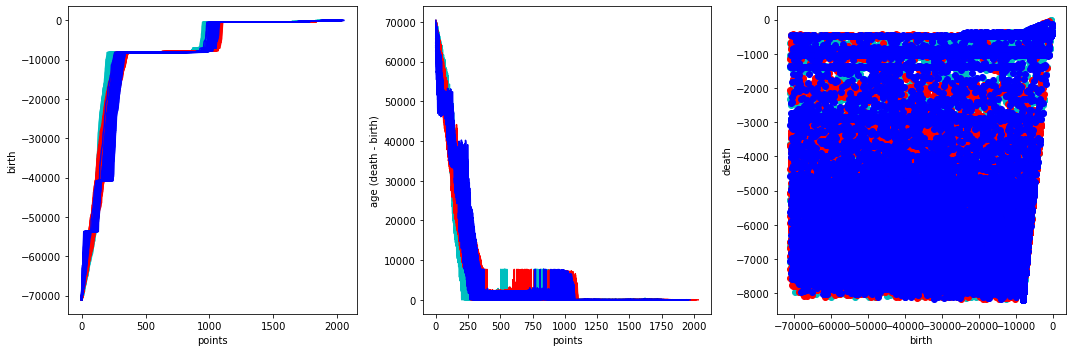

In [14]:
# visualize embeddings
import matplotlib as mpl
import matplotlib.cm as cm

import seaborn as sns

cmap = cm.Blues_r

colors = {0: "b",
          0.1: "c",
          0.2: "m",
          0.3: "r"}
_, (ax1, ax3, ax4) = plt.subplots(1, 3, figsize=(15, 5))
for eps in embeddings:
    if not eps in [0., 0.1, 0.3]: continue
    color = colors[eps]
    for x in embeddings[eps]:
        birth, death = np.transpose(x)
        age = death - birth
        ax1.plot(birth, c=color)
        ax1.set_ylabel("birth")
        ax1.set_xlabel("points")
        # ax2.plot(death, c=color)
        # ax2.set_ylabel("death")
        # ax2.set_xlabel("points")
        ax3.plot(age, c=color)
        ax3.set_ylabel("age (death - birth)")
        ax3.set_xlabel("points")
        ax4.scatter(birth, death, c=color);
        ax4.set_xlabel("birth")
        ax4.set_ylabel("death")
plt.tight_layout()

In [28]:
# Plot performance of the detector
import pandas as pd
import seaborn as sns

df = []
for key in ["supervised_metrics", "unsupervised_metrics"]:
    tmp = evaluation_results[key]
    if key == "unsupervised_metrics":
        sup = False
    else:
        sup = True
    for eps in tmp:
        df.append(dict(sup=sup, eps=eps, auc=tmp[eps]["auc"]["upper_bound"],
                       method="PersistentDiagram",
                       arch=lenet_arch.name))
df = pd.DataFrame(df)

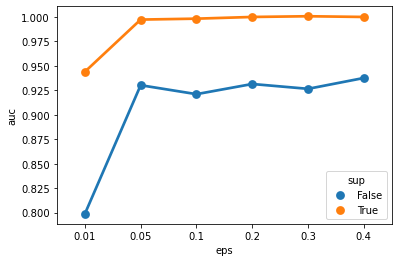

In [29]:
sns.pointplot(data=df, x="eps", y="auc", hue="sup");

In [17]:
df

,sup,eps,auc,method,arch
0,True,0.01,0.91280,PersistentDiagram,mnist_lenet
1,True,0.05,0.99265,PersistentDiagram,mnist_lenet
2,True,0.10,0.99055,PersistentDiagram,mnist_lenet
3,True,0.20,1.00000,PersistentDiagram,mnist_lenet
4,True,0.30,0.99895,PersistentDiagram,mnist_lenet
5,True,0.40,1.00000,PersistentDiagram,mnist_lenet
6,False,0.01,0.74115,PersistentDiagram,mnist_lenet
7,False,0.05,0.88555,PersistentDiagram,mnist_lenet
8,False,0.10,0.88370,PersistentDiagram,mnist_lenet
9,False,0.20,0.89500,PersistentDiagram,mnist_lenet


In [66]:
layers

In [67]:
lenet_arch.layers[-2].get_matrix()

{3: <500x800 sparse matrix of type '<class 'numpy.float64'>'
 	with 293000 stored elements in COOrdinate format>}

In [37]:
import scipy.sparse.linalg as slinalg

In [55]:
U, s, V = slinalg.svds(lenet_arch.layers[0].get_matrix()[], k=1)

(-0.5, 1999.5, 783.5, -0.5)

DEBUG:matplotlib.axes._base:not adjusting title pos because a title was already placed manually: 1.050000
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


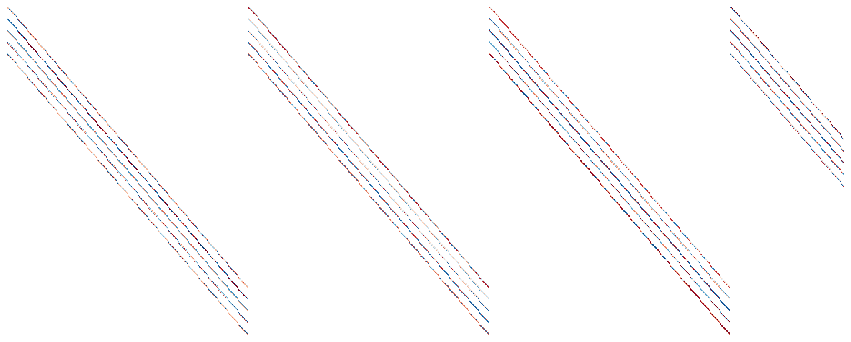

In [100]:
_, ax = plt.subplots(1, 1, figsize=(15, 8))
data = lenet_arch.layers[0].get_matrix()[-1].todense()[:2000].T
data = np.ma.masked_where(data == 0, data)
ax.matshow(data, cmap=plt.cm.RdBu);
ax.axis("off")

In [71]:
graph._edge_dict.keys()

dict_keys([(-1, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5)])

In [74]:
lenet_arch.layers[4].get_matrix()

{3: <500x800 sparse matrix of type '<class 'numpy.float64'>'
 	with 293000 stored elements in COOrdinate format>}

In [101]:
from tda.graph import Graph

Graph.from_architecture_and_data_point(lenet_arch, X_train[0])

In [103]:
graph.get_edge_list()

[([0, 784], 22376.815905826978),
 ([0, 1360], 26061.578925755155),
 ([0, 1936], 5601.015979873878),
 ([0, 2512], 95413.68347576725),
 ([0, 3088], 85345.92785011596),
 ([0, 3664], 33993.46651212169),
 ([0, 4240], 59624.05075936615),
 ([0, 4816], 61945.5277595845),
 ([0, 5392], 65700.16337606436),
 ([0, 5968], 62522.949145426486),
 ([0, 6544], 1024.7120054236864),
 ([0, 7120], 75396.55367290344),
 ([0, 7696], 52675.16919105421),
 ([0, 8272], 76651.28949502089),
 ([0, 8848], 63095.94069293599),
 ([0, 9424], 51843.837238837164),
 ([0, 10000], 19063.236308959426),
 ([0, 10576], 26820.518724787522),
 ([0, 11152], 89404.68642468257),
 ([0, 11728], 96163.37952259484),
 ([1, 784], 64306.73059033236),
 ([1, 785], 22376.815905826978),
 ([1, 1360], 47387.670281784965),
 ([1, 1361], 26061.578925755155),
 ([1, 1936], 76226.32235651776),
 ([1, 1937], 5601.015979873878),
 ([1, 2512], 10594.99434267),
 ([1, 2513], 95413.68347576725),
 ([1, 3088], 32757.668355606853),
 ([1, 3089], 85345.92785011596),
 (